# Homework Prompt Design

In the last lab we saw that there are different ways to get to the goal of the homework is to apply DoE to guage the effectiveness of different approaches. I.e.,  evaluate different algorithms/approaches that perform classification, and leveraging. **Design of Experiments**.


This homework consists the following 4 main parts, 1 facultative exercise to get to know a useful templating language, and 1 bonus exercise. Note the course staff reserves the right to provide corrections to this notebook and/or corresponding code.

**N.B.**, this homework is both about using different techniques, and applying DoE. Its purpose is *not* to obtain a State-of-the-Art result, but rather to get to know different methods, understand their respective merrits, and applying them properly.

## Submitting the Homework to Ilias
**N.B.** To submit this homework, you must render this notebook as a PDF, run the following command in the commandline. Make sure to test this command;

```bash
jupyter-nbconvert --to pdfviahtml  homework-reference.ipynb --TagRemovePreprocessor.remove_input_tags='{"hide-cell","hide-student-submission"}'  --TagRemovePreprocessor.remove_all_outputs_tags='{"remove-output"}'         
```

Before submitting make sure your notebook adheres to the following:

1. None of the cells that are tagged as `keep-output` or `hide-cell` are deleted, these are key for the review of your code.
2. You have verified that your submission PDF contains all your complete answers, note that;
   * cells annotated with `hide-cell` will have their input removed,
   * cells annotated with `remove-output` will have their output removed,
   * cells annotated with `hide-student-submission` will have their input removed, e.g., this cell
   
3. Any cells you have added are either: properly annotated with `keep-output` or `hide-cell`, or are manually cleaned.

> ⚠️ The course staff reserves the right to withold awarding (partial) points to any of the (sub)exercises if your submitted PDF and notebook do not adhere to these requirements.


---

# Homework 2 Submission

| **Detail**      | **Description**      |
|-----------------|----------------------|
| **Name**        | Bastien Dimitri Jossen |
| **Student No.** | 20-113-684           |
| **Year**        | 2024                 |
| **Course**      | MSGAI                |


# Before we get started

This notebook seems long, but *most of the code* provides a starting point for the objective of this homework; *basic prompt-design and DoE*.
Read each exercise carefully, you might find some hints here and there in the provided code!

## Homework Overview

This homework consists of the following three parts, each consisting of some implementation, and design of experiment. We provide skeleton code to perform the experiments, but you may wish to deviate from it. We recommend doing the exercises in the provided order.

1. Zero-shot / Instruction based prediction.
2. Few-shot / Example based prediction.
3. Fine-Tuning / Learning based prediction.

Each exercise consists of;
1. A minor implementation of the main concept (see above, except for the `Fine-Tuning / Learning exercise`).
2. Design-of-Experiments. We provide a (mostly filled out) example in Exercise 3 that you may wish to use in Exercises 1 and 2.
3. Analysis of the DoE results, using ANOVA analysis, herein you need to check the model assumptions.

Additionally, there is ONE bonus exercise (2.1.3), worth a maximum of $10$ points, which we recommend tackling last.
3. (Bonus) Classification based prediction / Anything you want. Note, contact the TA before starting this BONUS. This BONUS will be of max. 10 points instead of the Semantic Few-Shot Prompting bonus in exercise 2. You can use the results / insights from this also in your project work.

**N.B.** You can get a maximum of $60$ points in total, **with an additional maximum of $10$ bonus points**.

---


In [5]:
from numpy.ma.setup import configuration
from pyexpat import features

print("hello")

hello


In [6]:
import numpy as np
print(np.__version__)

1.26.4


In [7]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [8]:
import torch
print(torch.cuda.is_available())  # Should output: True
print(torch.version.cuda)  # Should match 12.4

False
None


In [180]:
# Install dependencies (same as the env file, so you may wish to skip this if running locally / with persistent conda environment)
%pip install python>=3.10,<4.0.0
%pip install nbconvert==6.5.4
%pip install lxml_html_clean==0.3.1
%pip install notebook-as-pdf==0.5.0
%pip install bitsandbytes~=0.42.0
%pip install configparser~=7.1.0
%pip install datasets>=3.0.1,<4.0.0
%pip install flake8-import-order~=0.18.2
%pip install fqdn~=1.5.1
%pip install isoduration~=20.11.0
%pip install jinja2schema~=0.1.4
%pip install jsonpointer~=3.0.0
%pip install jupyter~=1.1.1,<2.0.0
%pip install peft>=0.13.2,<1.0.0
%pip install pretty-jupyter==2.0.7
%pip install protobuf~=5.28.2,<6.0.0
%pip install pyDOE3~=1.0.4
%pip install researchpy~=0.3.6
%pip install seaborn~=0.13.2
%pip install sentence-transformers~=3.2.0
%pip install sentencepiece~=0.2.0,<1.0.0
%pip install tabulate~=0.9.0
%pip install uri-template==1.3.0
%pip install webcolors==24.8.0
%pip install datasets
%pip install peft
%pip install acetools

zsh:1: 3.10, not found
Note: you may need to restart the kernel to use updated packages.


OSError: [Errno 5] Input/output error

In [9]:
# Imports used in most of the exercises
import contextlib
import io
import json

import textwrap
import time
import unittest
import warnings
from collections import defaultdict
from importlib import metadata
from itertools import chain
from os import PathLike
from functools import partial
from typing import Dict, List, Tuple, Union, Dict, Any
from typing import Optional, Type
from unittest import TextTestRunner, defaultTestLoader

import datasets
import jinja2
import jinja2schema
import peft
import torch
import transformers
from IPython.display import HTML, Markdown, display
from tqdm.auto import tqdm
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import T5TokenizerFast

from pathlib import Path

In [10]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

base


In [11]:
def get_available_device() -> Tuple[torch.device, str]:
    """Helper method to find best possible hardware to run
    Returns:
        torch.device used to run experiments.
        str representation of backend.
    """
    # Check if CUDA is available
    if torch.cuda.is_available():
        return torch.device("cuda"), "cuda"

    # Check if ROCm is available
    if torch.version.hip is not None and torch.backends.mps.is_available():
        return torch.device("rocm"), "rocm"

    # Check if MPS (Apple Silicon) is available
    if torch.backends.mps.is_available():
        return torch.device('cpu'), "mps"

    # Fall back to CPU
    return torch.device("cpu"), "cpu"


def display_dataset_description(name: str, dataset: datasets.DatasetDict) -> None:
    """Helper method to display information about splits in the dataset.

    Args:
        name (str): Dataset name that was loaded.
        dataset (datasets.DatasetDict): Dataset dict with different splits that were loaded

    Returns:
        None
    """
    split_info = []
    for k, ds in dataset.items():
        split_info.append(f"<tr><td><strong>{k.capitalize()} Samples:</strong></td><td>{len(ds)}</td></tr>")
    html_content = f"""
    <h2>Dataset info</h2>
    <table>
        <tr><td><strong>Dataset Name:</strong></td><td>{name}</td></tr>
        {"<br>".join(split_info)}
    </table>
    """

    # Display the output in the notebook
    display(HTML(html_content))

def get_installed_version(package_name) -> str:
    with warnings.catch_warnings():
        # Supress warnings from packages that have missing attributes that metadata will complain about.
        warnings.simplefilter("ignore")
        distribution = metadata.Distribution()
        try:
            return distribution.from_name(package_name).version
        except metadata.PackageNotFoundError:
            return "Not installed"


def display_configuration() -> None:
    # Check device info
    device, backend = get_available_device()

    # Torch version
    torch_version = torch.__version__

    # HuggingFace Transformers version
    transformers_ver = transformers.__version__

    # BitsAndBytes version (if available)
    bitsandbytes_version = get_installed_version("bitsandbytes")

    # Check for GPU-specific details if CUDA or ROCm is available
    if device.type == "cuda":
        cuda_device_count = torch.cuda.device_count()
        cuda_device_name = torch.cuda.get_device_name(0)
        cuda_version = torch.version.cuda
    elif device.type == "rocm":
        cuda_device_count = torch.cuda.device_count()
        cuda_device_name = torch.cuda.get_device_name(0)
        cuda_version = torch.version.hip
    else:
        cuda_device_count = 0
        cuda_device_name = "N/A"
        cuda_version = "N/A"

    # Prepare HTML formatted output for better display in a notebook
    html_content = f"""
    <h2>System Configuration</h2>
    <table>
        <tr><td><strong>PyTorch version:</strong></td><td>{torch_version}</td></tr>
        <tr><td><strong>Device:</strong></td><td>{device} (Backend: {backend})</td></tr>
        <tr><td><strong>CUDA/ROCm version:</strong></td><td>{cuda_version}</td></tr>
        <tr><td><strong>GPU count:</strong></td><td>{cuda_device_count}</td></tr>
        <tr><td><strong>GPU name:</strong></td><td>{cuda_device_name}</td></tr>
        <tr><td><strong>Hugging Face Transformers version:</strong></td><td>{transformers_ver}</td></tr>
        <tr><td><strong>BitsAndBytes version:</strong></td><td>{bitsandbytes_version}</td></tr>
    </table>
    """

    # Display the output in the notebook
    display(HTML(html_content))


# Call the display_configuration() function in your Jupyter notebook to show the configuration
display_configuration()

PyTorch version:,2.3.0
Device:,cpu (Backend: cpu)
CUDA/ROCm version:,N/A
GPU count:,0
GPU name:,N/A
Hugging Face Transformers version:,4.46.1
BitsAndBytes version:,0.42.0


## 0. Preparation

In order to prepare, we will load the model and dataset that we will be using, namely the `standfordnlp/imbd` sentiment dataset, and the `google/flan-T5-small` model.

You likely only need to run these setup cells once before running your code, but you might want to use the functions we provide here for certain DoE variables concerning:

* Precision (`torch.float16`, `torch.float32`, `torch.bfloat16`)
* Quantization (E.g., `bits_and_bytes_config != None`)
* Device (E.g., `cpu` and `cuda`)



In [12]:
def get_model(
        model_name: Union[str, PathLike],
        model_type: Type[transformers.GenerationMixin] = T5ForConditionalGeneration,
        torch_dtype: torch.dtype = torch.float16,
        device=torch.device("cpu"),
        bits_and_bytes_config: Optional[transformers.BitsAndBytesConfig] = None
) -> Tuple[transformers.PreTrainedModel, transformers.PreTrainedTokenizer, Union[transformers.PreTrainedTokenizerFast, transformers.PreTrainedTokenizer]]:
    """Example method to instantiate a model and get a model with optional quantization (using bitsandbytes).

    Args:
        model_name (str): Model name (huggingface name), or relative/absolute path to a pretrained model.
        model_type (Type[transformers.PreTrainedModel]): Type of pretrained model, used to instantiate the model you wan to load.
        torch_dtype (torch.dtype, torch.float16): Precision to load the model with. See also the BitsAndBytes documentation.
        device (torch.device, 'cpu'): Device to run the model on.
        bits_and_bytes_config (BitsAndBytesConfig, optional): Configuration for bitsandbytes model quantization / mixed-precisions (consider this one of your factors)
            N.B. for fine-tuning, make sure the optimizer you want to use is available for the defined precision.

    Returns:
        transformers.PreTrainedModel: Model instance with provided configuraiton.
        transformers.PreTrainedTokenizer: Tokenizer instance with provided configuration.
        transformers.PreTrainedTokenizerFast: Fast tokenizer if avilable, othersiwe a normal python based optimizer

    Notes:
        For using the BitsAndBytes quantization configuration, an Nvidia GPU is required. For this you might want to make
        use of the Google Collab L4 / K40 GPUs (free-tier).

    """

    model: transformers.PreTrainedModel = model_type.from_pretrained(
        pretrained_model_name_or_path=model_name,
        quantization_config=bits_and_bytes_config,
        device_map=device,
        torch_dtype=torch_dtype,
    )
    tokenizer = transformers.AutoTokenizer.from_pretrained(
        pretrained_model_name_or_path=model_name,
    )
    fast_tokenizer = transformers.AutoTokenizer.from_pretrained(
        pretrained_model_name_or_path=model_name,
        use_fast=True
    )

    return model, tokenizer, fast_tokenizer

def get_dataset(
        data_name: str,
        splits: List[str]
) -> Tuple[datasets.Dataset, ...]:
    """Helper method to load huggingface dataset.

    Args:
        data_name (str): Dataset name to load from huggingface.
        splits (List[str]): List of splits to load and return.

    Returns:
        Tuple containing the dataset splits.
    """
    # Load dataset, and assign splits to variables
    dataset: datasets.DatasetDict = datasets.load_dataset(data_name)
    return tuple(dataset[split] for split in splits)

def simple_truncate_text(row, max_length=50, tokenizer: transformers.PreTrainedTokenizerFast = None):
    """Example of a simple truncation method text, based on token count.

    You might want to perform 'smarter' truncation / summarization as a level, instead of simply cutting of after `max_length` tokens.

    Examples:
        You might want to partially-apply the function, to provide a different tokenizer:
        ```python3
        from functools import partial
        some_other_tokenizer = transformers.AutoTokenizer.from_pretrained('your_fave_tokenizer')
        partial_simple_truncate = partial(simple_truncate_text, tokenizer=some_other_tokenizer)
        ```
    Args:
        row (datasets....): Single instance or row of dataset.

    Keyword Args:
        max_length (int, 150): the maximum length of text to be processed. Defaults to 150.
        tokenizer (transformers.PreTrainedTokenizer, `fast_tokenizer`): the tokenizer to use. Defaults to `fast_tokenizer`.

    Notes:
        This function requires all cells above to be run.
    """
    token_representation = tokenizer.batch_encode_plus(row['text'], max_length=max_length, truncation=True)['input_ids']
    text_representation = tokenizer.batch_decode(token_representation, skip_special_tokens=True)
    row['text'] = text_representation
    return row


In [13]:
# Create tokenizer for flan family
family: str = "google/flan-t5"
# For the Lab we will use a small model, just to provide some insight into usability.
model: str = f"small"
model_name: str = f"{family}-{model}"

tokenizer: T5Tokenizer
fast_tokenizer: T5TokenizerFast
model: T5ForConditionalGeneration

# NOTE, you might need to change this for different model Families
#   as T5 family specifically is a encoder-decoder whereas most text gen. models are
#   of type AutoModelForCausalLM.
model_type: Type[transformers.GenerationMixin] = transformers.AutoModelForSeq2SeqLM
# model_type: Type[transformers.GenerationMixin] = transformers.AutoModelForCausalLM
device, backend = get_available_device()
model, tokenizer, fast_tokenizer = get_model(
    model_name=model_name,
    model_type=model_type,
    torch_dtype=torch.bfloat16,
    device=device,
)
# Set the model to Evaluation to prevent creating a computational graph
model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (wo): 

In [14]:
import pandas as pd
data_name: str = 'stanfordnlp/imdb'
splits = ['train', 'test', 'unsupervised']
train_set, test_set, *_ = get_dataset(data_name, splits=splits)
text, label = f"{train_set[1239]['text'][:40]}...", train_set[1239]['label']
display(
    Markdown(
f"""
| Text  | Label   |
|:-----:|:-------:|
|{text} | {label} |
"""
    )
)


| Text  | Label   |
|:-----:|:-------:|
|i completely agree with jamrom4.. this w... | 0 |


In [15]:
df_train = pd.DataFrame(train_set)
print(np.sum(df_train['label']))
train_set_shuffled = train_set.shuffle().select(range(1000))
df_train = pd.DataFrame(train_set_shuffled)
print(np.sum(df_train['label']))

12500
470


## (Optional) Becoming a Jinja Ninja!

As a starting point for data-manipulation, here are some exercises to get used with Jinja! We recommend looking into Jinja templating, with variables and for loops.
As you will see, Jinja is a very flexible templating engine, that allows you to wrangle the IMDb dataset that we will use into the correct format for your experiments.

In the following exercises you can see how you can:

1. Render parameters in a Jinja Template
2. Render lists in a Jinja Template
3. Render `zip`ped list in a Jinja Template

> N.B. use the test methods to see what is expected / the expected return statement


In [16]:
example_template = jinja2.Template(
    textwrap.dedent(
        """\
        Hello my name is: {{ MY_NAME }}
        """
    )
)
print(example_template.render(MY_NAME="Jinja"))

# Implement a template that uses variables `course` `professor` and `ta`
# Would render `I follow MSGAIs 2024/2025 taught by Prof. L. Y. Chen, and can contact Ir. J. M. Galjaard for questions.`
VAR_TEMPLATE = textwrap.dedent(
    # YOUR CODE GOES HERE
    """\
    I follow {{course}} taught by {{professor}}, and can contact {{ta}} for questions.
    """
    # END OF YOUR CODE
)
variables_template = jinja2.Template(
    VAR_TEMPLATE
)
variables = jinja2schema.infer(VAR_TEMPLATE)
assert set(variables.keys()) == {'course', 'professor', 'ta'}, 'Not all variables are used'

# As example
print(variables_template.render(course ='MSGAIs 2024/2025', professor='L. Y. Chen', ta='J. M. Galjaard'))


Hello my name is: Jinja
I follow MSGAIs 2024/2025 taught by L. Y. Chen, and can contact J. M. Galjaard for questions.


In [17]:
# TODO: Implement a template that uses a variable `exercises` that contains a list of strings.
#  it should render as a Markdown list
# HINT: use a jinja for-loop
list_expected = """I need to implement:
 * Basic prompting
 * Few-shot Learning
 * Fine-Tuning
 * Bonus"""
LIST_TEMPLATE = textwrap.dedent(
    """\
    I need to implement:{% for exercise in exercises %}
    * {{ exercise }}{% endfor %}
    """
)
list_template = jinja2.Template(
    LIST_TEMPLATE
)
variables = jinja2schema.infer(LIST_TEMPLATE)
assert 'exercises' in set(variables.keys()), 'Exercise variables is not used!'
print(list_template.render(exercises=['Basic prompting', 'Few-shot Learning', 'Fine-Tuning', 'Bonus']))

I need to implement:
* Basic prompting
* Few-shot Learning
* Fine-Tuning
* Bonus


In [18]:
# TODO: Implement a template that uses a variable `points_exercises` that contains a list of tuples.
# HINT: use a jinja for-loop and variable unrolling
zip_expected = """I need to implement:
* (20) Basic prompting
* (20) Few-shot Learning
* (20) Fine-Tuning
* (10) Bonus"""

ZIP_TEMPLATE = textwrap.dedent(
    # YOUR CODE GOES HERE
    """\
    I need to implement:{% for points, exercise in points_exercises%}
    * ({{points}}) {{exercise}} {% endfor %}
    """
    # END OF YOUR CODE
)
zip_template = jinja2.Template(
    ZIP_TEMPLATE
)
variables = jinja2schema.infer(ZIP_TEMPLATE)
assert set(variables.keys()) == {'points_exercises'}, 'Exercise variables is not used!'
print(zip_template.render(points_exercises=[(20, 'Basic prompting'), ( 20, 'Few-shot Learning'), (20, 'Fine-Tuning'), (10, 'Bonus')]))

I need to implement:
* (20) Basic prompting 
* (20) Few-shot Learning 
* (20) Fine-Tuning 
* (10) Bonus 


In [19]:
# Do not edit the following code.
class TestJinjaNinja(unittest.TestCase):
    exercises = ['Basic prompting', 'Few-shot Learning', 'Fine-Tuning', 'Bonus']
    points = [20, 20, 20, 10]
    def test_1_variable(self):

        check_against = "I follow MSGAIs 2024/2025 taught by Prof. L. Y. Chen, and can contact Ir. J. M. Galjaard for questions."
        course = 'MSGAIs 2024/2025'
        professor = 'Prof. L. Y. Chen'
        ta = 'Ir. J. M. Galjaard'
        result = variables_template.render(course=course, professor=professor, ta=ta)
        self.assertEqual(result, check_against)

    def test_2_list_template(self):
        check_against = textwrap.dedent("""\
        I need to implement:
        * Basic prompting
        * Few-shot Learning
        * Fine-Tuning
        * Bonus""")
        result = list_template.render(exercises=self.exercises)
        self.assertEqual(result, check_against)


    def test_3_list_zipped(self):
        check_against = textwrap.dedent("""\
        I need to implement:
        * (20) Basic prompting
        * (20) Few-shot Learning
        * (20) Fine-Tuning
        * (10) Bonus""")

        result = zip_template.render(points_exercises=list(zip(self.points, self.exercises)))
        self.assertEqual(result, check_against)

f = io.StringIO()
with contextlib.redirect_stderr(f):
    display(Markdown("### Exercise 0.1 Optional exercise result"))
    TextTestRunner(verbosity=-1).run(defaultTestLoader.loadTestsFromTestCase(TestJinjaNinja))
    display(Markdown('---'))
    print(f"\033[91m{f.getvalue()}")

### Exercise 0.1 Optional exercise result

---

FAIL: test_3_list_zipped (__main__.TestJinjaNinja.test_3_list_zipped)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/var/folders/d2/0s_5ml6930z0wfpjk4kgrl0r0000gn/T/ipykernel_54354/2669531984.py", line 34, in test_3_list_zipped
    self.assertEqual(result, check_against)
AssertionError: 'I ne[35 chars]pting \n* (20) Few-shot Learning \n* (20) Fine[19 chars]nus ' != 'I ne[35 chars]pting\n* (20) Few-shot Learning\n* (20) Fine-T[15 chars]onus'
  I need to implement:
- * (20) Basic prompting 
?                       -
+ * (20) Basic prompting
- * (20) Few-shot Learning 
?                         -
+ * (20) Few-shot Learning
- * (20) Fine-Tuning 
?                   -
+ * (20) Fine-Tuning
- * (10) Bonus 
?             -
+ * (10) Bonus


----------------------------------------------------------------------
Ran 3 tests in 0.001s

FAILED (failures=1)



# Exercise 1: Prompt-based Evaluation (20 points total)
Instead of fine-tuning a model specific to a problem, we can use the language model's capability to follow instructions to perform a specific task. In all these tasks, we will make use of the IMDB movie review sentiment dataset. Throughout this, and following exercises, we will be 'asking' the model to predict the sentiment (Positive or Negative).

A naive idea, is ask the model simply: ``Has the following a Positive or Negative sentiment?''.

In this exercise, you will;

1. **Exercise 1.1**     (5 points) implement two 'Zero-Shot' prompts 'templates', that prompt the model to decide upon the semtiment without additional information
2. **Exercise 1.2:**    (8 points) Perform DoE with different system- and/or hyper-parameters during generation, to evaluate how they impact the models performance (accuracy).
3. **Exercise 1.3:**    (7 points) Analyse the result of your DoE experiments, usign ANOVA.


The goal here is to evaluate the impact of different hyper-parameters and/or system-parameters on the classification accuracy of the model.

> ❗One of the levels in your DoE, will be the input representation, i.e., a `simple_prompt` and a more contextual `detailed_prompt`. You will implement these Zero-Shot prompts. The simple prompt should be a mere short question, whereas the detailed prompt should give additional context, e.g., about the domain / task that is performed.


> *N.B.* to guide you through the exericse, we annotate things you will need to implement. In the lab we will provide some example on how to tackle this.

 ```python
 # YOUR CODE GOES HERE!

 # END OF YOUR CODE!
 ```

**⚠ FAIR Warning:**

> YOU should make sure to store results to disk or other persisten storage, i.e. by writing to a file or saving a model. For example when you want to run with different models you should make sure that data is not accidentally overwritten!


## Exercise: 1.1 Prompt-Design (5 points)

First, we ensure that we can represent the data to the model with our designed prompt, for this, you will need to implement the following behavior;

1. A simple (yes/no)-like question for the prompt in `get_simple_prompt_template`. (2 points (left / right)).
    * This should ask for a `positive`/`Positive` or `negative`/`Negative` as answer, i.e., asking to classify the sentiment of text.
2. A detailed (contextual) question for the prompt in `get_detailed_prompt_template`. (3 points (left / right)).
    * This should ask for a `positive`/`Positive` or `negative`/`Negative` as answer, i.e., asking to classify the sentiment of text.
    * The question should provide additional context regarding the task that is performed (e.g., sentiment analysis, type of task that is peformed, etc.).


**N.B**, we don't recommend using a library like `langchain` to do the homework, as they can become restrictive in the specifics that you want to use. You can opt to use it, but the course does not provide support on additional optional frameworks.

**N.B.** we do recommend using Jinja to create templates for prompts. This allows to quickly transform input for your experiments for your execution of DoE.

Additionally, make sure to use the appropriate `textwrap.dedent` option, if you use triple-quoted (multi-line) `str`ings! Otherwise, you will add (unintenional) whitespace `char`s!

> If you are unsure how to do this, see the Preparation exercise above, as they provide some hints.


In [20]:
def get_simple_prompt_template(
        side: str = 'left',
) -> jinja2.Template:
    """Implements a simple Template retrieval function, that takes as argument `review` and renders as a simple prompt.
    Keyword Args:
        side (str, 'left'): Position at which to add the question for the prompt.

    Returns:
        jinja.Template that can render an argument `review`, consisting of a string represention of a review.
    """
    # TODO: Implement a simple zero-shot style yes/no style QA Template.
    match side:
        case 'left':
            # TODO: Implement question first, then `review`

            PROMPT_TEMPLATE = textwrap.dedent(
                # YOUR CODE GOES HERE
                """\
                Positiv/Negativ?
                {{ review }}
                """
                # END OF YOUR CODE
            )
        case 'right':
            # TODO: Implement `review` first, then question
            PROMPT_TEMPLATE = textwrap.dedent(
                # YOUR CODE GOES HERE
                """\
                {{ review }}
                Positiv/Negativ?
                """
                # END OF YOUR CODE
            )
    assert set(jinja2schema.infer(PROMPT_TEMPLATE).keys()) == {'review'}, "Your template does not use the `review` argument."
    return jinja2.Template(PROMPT_TEMPLATE)



simple_template_l = get_simple_prompt_template(side='left')

simple_template_r = get_simple_prompt_template(side='right')

display(
    Markdown(
        simple_template_l.render(review='Review would go here...').replace('\n', '<br>')
    )
)

Positiv/Negativ?<br>Review would go here...

In [21]:
# RUN EVALUATION
# Don't change the code below.

def nl_to_br(inp, br: str='<br>'):
    return inp.replace('\n', br)

example_review = f"{train_set[1203]['text'][:142]}..."
simple_prompt_l = nl_to_br(simple_template_l.render(review='Review would go here...'))
simple_example_l = nl_to_br(simple_template_l.render(review=example_review))

simple_prompt_r = nl_to_br(simple_template_r.render(review='Review would go here...'))
simple_example_r = nl_to_br(simple_template_r.render(review=example_review))

display(
    Markdown('### Exericse 1.1.1 Result'),
    HTML(
        textwrap.dedent(
            f"""\
            <table style="border-collapse: collapse; width: 100%;">
                <tr>
                    <th style="text-align: left; border: 1px solid black;">My simple prompt (left)</th>
                    <th style="text-align: left; border: 1px solid black;">My simple prompt (right)</th>
                </tr>
                <tr>
                    <td style="text-align: left; border: 1px solid black;">{simple_prompt_l}</td>
                    <td style="text-align: left; border: 1px solid black;">{simple_prompt_r}</td>
                </tr>
                <tr>
                    <th style="text-align: left; border: 1px solid black;">Example</th>
                    <th style="text-align: left; border: 1px solid black;">Example</th>
                </tr>
                <tr>
                    <td style="text-align: left; border: 1px solid black;">{simple_example_l}</td>
                    <td style="text-align: left; border: 1px solid black;">{simple_example_r}</td>
                </tr>
            </table>"""
        )
    )
)

### Exericse 1.1.1 Result

My simple prompt (left),My simple prompt (right)
Positiv/Negativ?Review would go here...,Review would go here...Positiv/Negativ?
Example,Example
"Positiv/Negativ?Wow. Rarely have I felt the need to comment on movies lately, but this one especially is begging for a beatdown. Let's start at the beginning....","Wow. Rarely have I felt the need to comment on movies lately, but this one especially is begging for a beatdown. Let's start at the beginning....Positiv/Negativ?"


In [22]:
def get_detailed_prompt_template(
        side='left',
) -> jinja2.Template:
    """Implements a detailed contextual Template retrieval function, that takes as argument `review` and renders a detailed prompt
    with contextual information.

    Keyword Args:
        side (str, 'left'): Position at which to add the question for the prompt.

    Returns:
        Template that can render an argument `review`, consisting of a string representation of a review.
    """
    match side:
        case 'left':
            # TODO: Implement Question-first, Context second template.
            PROMPT_TEMPLATE = textwrap.dedent(
                # YOUR CODE GOES HERE
                """\
                As a sentiment analysis expert, please determine whether the following movie review expresses a positive or negative sentiment.
                {{ review }}
                """
                # END OF YOUR CODE
            )
        case 'right':
            # TODO: Implement Context-first, Question-second template.
            PROMPT_TEMPLATE = textwrap.dedent(
                # YOUR CODE GOES HERE
                """\
                {{ review }}
                Based on the above text, as a sentiment analysis expert, please determine whether the sentiment expressed in the movie review is positive or negative.
                """
                # END OF YOUR CODE
            )
    assert set(jinja2schema.infer(PROMPT_TEMPLATE).keys()) == {'review'}, "Your template does not use the `review` argument."
    return jinja2.Template(PROMPT_TEMPLATE)

detailed_template_l = get_detailed_prompt_template(
    side='left',
)
detailed_template_r = get_detailed_prompt_template(
    side='right',
)

display(
    Markdown(
        detailed_template_l.render(review='Review would go here...').replace('\n', '<br>')
    )
)

As a sentiment analysis expert, please determine whether the following movie review expresses a positive or negative sentiment.<br>Review would go here...

In [23]:
# RUN EVALUATION
# Don't change the code below.
example_review = f"{train_set[1203]['text'][:142]}..."

detailed_prompt_l = nl_to_br(detailed_template_l.render(review='Review would go here...'))
detailed_example_l = nl_to_br(detailed_template_l.render(review=example_review))

detailed_prompt_r = nl_to_br(detailed_template_r.render(review='Review would go here...'))
detailed_example_r = nl_to_br(detailed_template_r.render(review=example_review))

display(
    Markdown('### Exericse 1.1.2 Result'),
    HTML(
        textwrap.dedent(
            f"""\
            <table style="border-collapse: collapse; width: 100%;">
                <tr>
                    <th style="text-align: left; border: 1px solid black;">My detailed prompt (left)</th>
                    <th style="text-align: left; border: 1px solid black;">My detailed prompt (right)</th>
                </tr>
                <tr>
                    <td style="text-align: left; border: 1px solid black;">{detailed_prompt_l}</td>
                    <td style="text-align: left; border: 1px solid black;">{detailed_prompt_r}</td>
                </tr>
                <tr>
                    <th style="text-align: left; border: 1px solid black;">Example</th>
                    <th style="text-align: left; border: 1px solid black;">Example</th>
                </tr>
                <tr>
                    <td style="text-align: left; border: 1px solid black;">{detailed_example_l}</td>
                    <td style="text-align: left; border: 1px solid black;">{detailed_example_r}</td>
                </tr>
            </table>"""
        )
    )
)

### Exericse 1.1.2 Result

My detailed prompt (left),My detailed prompt (right)
"As a sentiment analysis expert, please determine whether the following movie review expresses a positive or negative sentiment.Review would go here...","Review would go here...Based on the above text, as a sentiment analysis expert, please determine whether the sentiment expressed in the movie review is positive or negative."
Example,Example
"As a sentiment analysis expert, please determine whether the following movie review expresses a positive or negative sentiment.Wow. Rarely have I felt the need to comment on movies lately, but this one especially is begging for a beatdown. Let's start at the beginning....","Wow. Rarely have I felt the need to comment on movies lately, but this one especially is begging for a beatdown. Let's start at the beginning....Based on the above text, as a sentiment analysis expert, please determine whether the sentiment expressed in the movie review is positive or negative."


In [24]:
def get_hybrid_prompt_template(
        side='left',
) -> jinja2.Template:
    """Implements a detailed contextual Template retrieval function, that takes as argument `review` and renders a detailed prompt
    with contextual information.

    Keyword Args:
        side (str, 'left'): Position at which to add the question for the prompt.

    Returns:
        Template that can render an argument `review`, consisting of a string representation of a review.
    """
    match side:
        case 'left':
            # TODO: Implement Question-first, Context second template.
            PROMPT_TEMPLATE = textwrap.dedent(
                # YOUR CODE GOES HERE
                """\
                Is the following sentiment positive or negative?
                {{ review }}
                """
                # END OF YOUR CODE
            )
        case 'right':
            # TODO: Implement `review` first, then question
            PROMPT_TEMPLATE = textwrap.dedent(
                # YOUR CODE GOES HERE
                """\
                {{ review }}
                Is the sentiment above positive or negative?
                """
                # END OF YOUR CODE
            )
    assert set(jinja2schema.infer(PROMPT_TEMPLATE).keys()) == {'review'}, "Your template does not use the `review` argument."
    return jinja2.Template(PROMPT_TEMPLATE)

hybrid_template_l = get_hybrid_prompt_template(
    side='left',
)
hybrid_template_r = get_hybrid_prompt_template(
    side='right',
)

display(
    Markdown(
        hybrid_template_l.render(review='Review would go here...').replace('\n', '<br>')
    )
)

Is the following sentiment positive or negative?<br>Review would go here...

In [25]:
# RUN EVALUATION
# Don't change the code below.
example_review = f"{train_set[1203]['text'][:142]}..."

hybrid_prompt_l = nl_to_br(hybrid_template_l.render(review='Review would go here...'))
hybrid_example_l = nl_to_br(hybrid_template_l.render(review=example_review))

hybrid_prompt_r = nl_to_br(hybrid_template_r.render(review='Review would go here...'))
hybrid_example_r = nl_to_br(hybrid_template_r.render(review=example_review))

display(
    Markdown('### Exericse 1.1.2 Result'),
    HTML(
        textwrap.dedent(
            f"""\
            <table style="border-collapse: collapse; width: 100%;">
                <tr>
                    <th style="text-align: left; border: 1px solid black;">My hybrid prompt (left)</th>
                    <th style="text-align: left; border: 1px solid black;">My hybrid prompt (right)</th>
                </tr>
                <tr>
                    <td style="text-align: left; border: 1px solid black;">{hybrid_prompt_l}</td>
                    <td style="text-align: left; border: 1px solid black;">{hybrid_prompt_r}</td>
                </tr>
                <tr>
                    <th style="text-align: left; border: 1px solid black;">Example</th>
                    <th style="text-align: left; border: 1px solid black;">Example</th>
                </tr>
                <tr>
                    <td style="text-align: left; border: 1px solid black;">{hybrid_example_l}</td>
                    <td style="text-align: left; border: 1px solid black;">{hybrid_example_r}</td>
                </tr>
            </table>"""
        )
    )
)

### Exericse 1.1.2 Result

My hybrid prompt (left),My hybrid prompt (right)
Is the following sentiment positive or negative?Review would go here...,Review would go here...Is the sentiment above positive or negative?
Example,Example
"Is the following sentiment positive or negative?Wow. Rarely have I felt the need to comment on movies lately, but this one especially is begging for a beatdown. Let's start at the beginning....","Wow. Rarely have I felt the need to comment on movies lately, but this one especially is begging for a beatdown. Let's start at the beginning....Is the sentiment above positive or negative?"


In [26]:
# Create the truncated eval set.
MAX_50_TOKENS = 50
truncate_to_50_tokens = partial(simple_truncate_text,  max_length=MAX_50_TOKENS, tokenizer=fast_tokenizer)
truncate_to_100_tokens = partial(simple_truncate_text,  max_length=100, tokenizer=fast_tokenizer)


q1_eval_set = (
    test_set
    .map(truncate_to_50_tokens, batched=True)
)

truncated_example_text, label = nl_to_br(q1_eval_set[0]['text']), q1_eval_set[0]['label']
display(
    Markdown(
    """## Example of truncated data
Do you see how the text is abruptly terminated after `I tried to like this, I`?
"""),
    Markdown(textwrap.dedent(
            f"""\
            > | **Truncated Review**          | **Label** |
            |-------------------------------|-----------|
            | {truncated_example_text}      | {label}   |
            """
        )
    ),
    Markdown('---')
)

positive_count = [q1_eval_set[i]['label'] for i in range(len(q1_eval_set))].count(1)

negative_count = [q1_eval_set[i]['label'] for i in range(len(q1_eval_set))].count(0)
if positive_count > 0:
    neg_to_pos_ratio = negative_count / positive_count
else:
    neg_to_pos_ratio = float('inf')  # Handle division by zero
    
print(f"Negative to Positive ratio: {neg_to_pos_ratio:.2f}")


## Example of truncated data
Do you see how the text is abruptly terminated after `I tried to like this, I`?


> | **Truncated Review**          | **Label** |
|-------------------------------|-----------|
| I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I      | 0   |


---

Negative to Positive ratio: 1.00


## Exercise 1.2: Design of Experiments (8 points)

In this and the following exercise, we are interested in quantifing the effect of different configurations on the zero-shot performance of the model, you will need to select at-least 3 system- and/or hyper-parameters, with each having atleast two or more (2+) levels. Recall that for the first hyper-parameter should use the (`simple` or `detailed`) prompt.

Furthermore, we suggest using one or more from the following parameters in your DoE:

  * The structure of each prompt (i.e., `left` and `right`)
  * Model size, for example (`T5-flan-small`, `T5-flan-base`, `T5-flan-large`, etc.). (only recommended with GPU)
  * Numerical precision (`torch.float16`, `torch.float32`, `torch.bfloat16`). Make sure your hardware / `PyTorch` version supports this!
  * Quantization (only recommended with GPU with `BitsAndBytes` packages).
  * Structured decoding (requires implememtantation).


In short, you will need to perform;

1. (8 points) Design of Experiments in code;
    * Selection of criteria
    * Type of factorial experiment
    * Creation of experimental configuration
    * Run your experiments.
        * Depending on your chosen variables in DoE, you might need to make some minor adaptations to our provided code.

> For your convenience, we have split first DoE part,  and the Design of Experiments (which you have to implement), and the ANOVA analysis into 2 cells. We strongly recommend writing data to disk/persistent storage and loading it in the next cell to make sure you can easily re-run evaluation upon restarting the notebook.


In [27]:
from transformers import GenerationConfig


# Updated run_q1_evaluation function
def run_q1_evaluation(
        dataloader: torch.utils.data.DataLoader,
        model: transformers.PreTrainedModel,
        generation_config_dict: dict,
        *args,
        **kwargs
) -> Tuple[List[List[str]], List[List[int]]]:
    """Helper function to run evaluation (e.g. under different evaluations).
    
    Args:
        dataloader (torch.utils.data.DataLoader): Dataloader containing the evaluation set. 
        model (transformers.PreTrainedModel): Pre-Trained model to be evaluated.
        generation_config_dict: Generation configuration, provided as a dictionary.
        *args: Any additional positional args you want to add.
        **kwargs: Any additional keyword args you want to add.

    Returns:
        List of list containing the `str`ing representation of the model's prediction.
        List of list containing the `int`eger representation of the ground-truth label.
    """
    prediction_list, label_list = [], []
    # Create a GenerationConfig object
    generation_config = GenerationConfig(**generation_config_dict)

    
    for idx, batch in (pbar := tqdm(enumerate(dataloader), leave=False, total=len(dataloader))):
        pbar.set_description(f'Batch {idx}')
        # Rest of your code


        
        input_ids, attention_mask, label = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)

        
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            generation_config=generation_config,
            max_new_tokens=5,
        )
        prediction = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        prediction_list.append(prediction)
        label_list.append(label.cpu().tolist())

    return prediction_list, label_list

def get_q1_sets(
        dataset: datasets.Dataset
) -> Tuple[datasets.Dataset,datasets.Dataset , datasets.Dataset]:
    """Helper method to create the low and high level datasets with the `simple` and `detailed` prompt.
    
    Notes:
        You likely don't need to edit this code, but feel free to extend this code, in case you want to
        evaluate more different levels
    
    Args:
        dataset (datasets.Dataset): Dataset to be mapped to a simple and detailed representation dataset.
        
    Returns:
        Dataset with text mapped using the `simple_template`.
        Dataset with text mapped using the `detailed_template`.
    """
    # 1. Prepare the simple set (low level)
    simple_set = (
        dataset
        .map(
            lambda batch: fast_tokenizer.batch_encode_plus(
                [simple_template.render(review=row) for row in batch['text']],
                truncation=False,
                padding=True,
            ),
            batched=True,
        )
    )
    # Map to input expected by the model.
    simple_set.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    
    hybrid_set = (
        dataset
        .map(
            lambda batch: fast_tokenizer.batch_encode_plus(
                [hybrid_template.render(review=row) for row in batch['text']],
                truncation=False,
                padding=True,
            ),
            batched=True,
        )
    )
    # Map to input expected by the model
    hybrid_set.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    
    # 2. Prepare the detailed set (high level)
    detailed_set = (
        dataset
        .map(
            lambda batch: fast_tokenizer.batch_encode_plus(
                [detailed_template.render(review=row) for row in batch['text']],
                truncation=False,
                padding=True,
            ),
            batched=True,
        )
    )
    # Map to input expected by the model
    detailed_set.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    
    return simple_set, hybrid_set, detailed_set

### Exericse 1.2.1 Design of Experiments
Define your Design of Experiment configurations in the list `EXPERIMENT_CONFIGURATIONS`, you can use this list to store experiment configurations for the different levels.

In [242]:
# TODO: Implement your experimental design here! Decide on hyper-parameters, levels,
#  and type of factorial experiment you want to do.
# YOUR CODE GOES HERE
from itertools import product
import torch

EXPERIMENT_CONFIGURATIONS = []

sides = ['left', 'right']
# sides = ['left']
sizes = ['small','base']
torch_dtypes = [torch.float16,torch.float32] #torch.bfloat16, torch.float16

for side, torch_dtype, size in product(sides, torch_dtypes, sizes):
    EXPERIMENT_CONFIGURATIONS.append({
        'side': side,
        'size': size,
        'torch_dtype': torch_dtype,
    })
# END OF YOUR CODE

In [243]:
print(len(EXPERIMENT_CONFIGURATIONS))

8


In [244]:
import torch
print(torch.version.cuda)

None


In [245]:
# ONLY SET THIS TO True IFF YOU NEED TO RE-RUN EXPERIMENTS, AS IT WILL
#  OVERWRITE YOUR RESULTS.
ALLOW_OVERWRITING_RESULTS = False
"""
# If you want to experiment with the side of the prompt, you will need to make
#  some changes here.
"""
simple_template_left = get_simple_prompt_template(side='left')
hybrid_template_left = get_hybrid_prompt_template(side='left')
detailed_template_left = get_detailed_prompt_template(side='left')

simple_template_right = get_simple_prompt_template(side='right')
hybrid_template_right = get_hybrid_prompt_template(side='right')
detailed_template_right = get_detailed_prompt_template(side='right')


simple_templates = {"left": simple_template_left, "right": simple_template_right}
hybrid_templates = {"left": hybrid_template_left, "right": hybrid_template_right}
detailed_templates = {"left": detailed_template_left, "right": detailed_template_right}

sample_size = 5000

for configuration in (exp_bar := tqdm(EXPERIMENT_CONFIGURATIONS, leave=True)):
    # EXAMPLE CODE HERE
    # Determine the maximum lenght given the length of your prompts. 
    # N.B. You might want to use this, but as we propose a pre-tokenized
    # Prepare datasets
    family: str = "google/flan-t5"
    # For the Lab we will use a small model, just to provide some insight into usability.
    model: str = f"{configuration['size']}"
    model_name: str = f"{family}-{model}"
    
    model_type: Type[transformers.GenerationMixin] = transformers.AutoModelForSeq2SeqLM
    device, backend = get_available_device()
    model, tokenizer, fast_tokenizer = get_model(
        model_name=model_name,
        model_type=model_type,
        torch_dtype=configuration['torch_dtype'],
        device=device,
    )
    
    simple_template = simple_templates[configuration["side"]]
    hybrid_template = hybrid_templates[configuration["side"]]
    detailed_template = detailed_templates[configuration["side"]]
    
    simple_set, hybrid_set, detailed_set = get_q1_sets(q1_eval_set)
    
    simple_overhead = len(tokenizer(simple_templates[configuration["side"]].render(), add_special_tokens=False)['input_ids'])
    hybrid_overhead = len(tokenizer(hybrid_templates[configuration["side"]].render(), add_special_tokens=False)['input_ids'])
    detailed_overhead = len(tokenizer(detailed_templates[configuration["side"]].render(), add_special_tokens=False)['input_ids'])
    
    # generation_config_dict = {
    #         'num_beams': 5 if configuration['decoding_strategy'] == 'beam_search' else None,
    #         'do_sample': configuration['decoding_strategy'] == 'greedy',
    #     }
    
    """
    # You might need to subsample the dataset to 1000, if your hardware is too slow. Make sure to report
    #   if and how you sub-sample
    simple_set, detailed_set = simple_set.sample(...), detailed_set.sample(...)
    """
    for i in range(5):
        simple_set_sample = simple_set.shuffle().select(range(sample_size))
        hybrid_set_sample = hybrid_set.shuffle().select(range(sample_size))
        detailed_set_sample = detailed_set.shuffle().select(range(sample_size))
        for split, dataset in (split_bar := tqdm(zip(['simple','hybrid', 'detailed'], [simple_set_sample, hybrid_set_sample, detailed_set_sample]), leave=False, total=3)):
            q_data_loader = torch.utils.data.DataLoader(
                dataset=dataset,
                batch_size=15,  # Feel free to lower / higher this
                shuffle=False,  # Shuffling not needed during evaluation
                num_workers=2,
                prefetch_factor=10,
            )
            
            begin_time = time.time()
            prediction_list, label_list = run_q1_evaluation(
                q_data_loader,  # This you should probably not change
                model,  # You might need to change / load a different model for model-parameter
                configuration,  # You might need to update some kwargs int the generation config for your exp.
            )
            end_time = time.time()
            # Create a flat version to work with.
            prediction_list, labels_list = list(chain(*prediction_list)), list(chain(*label_list))
            # TODO: Store your results in a way such that you can load it later!
            # YOUR CODE GOES HERE
            total_time = end_time - begin_time
            # END OF YOUR CODE
            
            # Map the output if we don't recognize it to 
            label_lut = defaultdict(lambda: -1, {'positive': 1, 'negative': 0})
            
            predictions = list(map(lambda x: label_lut[x.split(' ')[0].lower()], prediction_list))
            
            accuracy = sum(map(lambda x: x[0] == x[1], zip(predictions, labels_list))) / len(predictions)
            unknown =  sum(map(lambda x: x[0] == -1, zip(predictions, labels_list))) / len(predictions)
            
            pos_count = predictions.count(1)
            neg_count = predictions.count(0)
            print("pos predinctions: ", pos_count)
            print("neg predictions: ", neg_count)
            if (neg_count + pos_count) == 0:
                print("No predictions")
                pred_ratio = None
            else:
                pred_ratio = neg_count / (neg_count + pos_count)
                print("prediction ratio neg to pos:", pred_ratio)
            act_ratio = 1-(sum(labels_list) / len(labels_list))
            print("Actual ratio neg to pos:", act_ratio)
            
            print(f"Accuracy ({split}): {accuracy}, Unknown: {unknown}")
            experiment_description = f"{split}_{configuration['side']}_{configuration['size']}_{configuration['torch_dtype']}"
            save_path_experiment = f"results/Run{i+1}/experiment_{experiment_description}.json"
            
            # Write file to disk
            save_path = Path(save_path_experiment)
            if not save_path.parent.exists():
                # Recursively create directory
                save_path.parent.mkdir(exist_ok=True, parents=True)
            if save_path.is_file() and not ALLOW_OVERWRITING_RESULTS:
                print("YOU ARE TRYING TO OVERWRITE AN EXISTING EXPERIMENT FILE!")
                raise Exception("Cannot overwrite existing experiment file without `ALLOW_OVERWRITING_RESULTS` flag set.")
            
            with open(save_path, 'w') as f:
                # TODO: You might want to save some additional results.
                json.dump({
                    "description": experiment_description,
                    "accuracy": accuracy,
                    "unknown": unknown,
                    "prediction_ratio": pred_ratio,
                    "actual_ratio": act_ratio,
                    "begin_time": begin_time,
                    "end_time": end_time,
                    "total_time": total_time,
                }, f)
                

  0%|          | 0/8 [00:00<?, ?it/s]

/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/334 [00:00<?, ?it/s]

RuntimeError: "addmm_impl_cpu_" not implemented for 'Half'

### Exercise 1.3 Report on DoE (7 points)

In [24]:
import json
from pathlib import Path
from typing import List, Dict
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt

# Function to load experiment results from multiple run directories
def load_experiment_results(results_dirs: List[str]) -> List[Dict]:
    results = []
    for results_dir in results_dirs:
        for result_file in Path(results_dir).rglob('*.json'):
            with open(result_file, 'r') as f:
                results.append(json.load(f))
    return results

# Load results from Run1 to Run5 directories
results_dirs = [f'results_revised/Run{i}' for i in range(1, 6)]
results = load_experiment_results(results_dirs)

In [25]:
# Convert results to a DataFrame
df = pd.DataFrame(results)

# Group by the experiment description and calculate the mean for each metric
grouped_df = df.groupby('description').mean().reset_index()

properties = ['split','side','size','torch_dtype']
grouped_df[properties] = grouped_df['description'].str.split('_', expand=True)
grouped_df['accuracy'] = grouped_df['accuracy'].astype(float)
grouped_df['unknown'] = grouped_df['unknown'].astype(float)
grouped_df['prediction_ratio'] = grouped_df['prediction_ratio'].astype(float)
grouped_df['actual_ratio'] = grouped_df['actual_ratio'].astype(float)
grouped_df.drop(columns=['description'], inplace=True)
grouped_df.drop(columns=['begin_time'], inplace=True)
grouped_df.drop(columns=['end_time'], inplace=True)

# Order dataframe split -> side -> size -> torch_dtype -> accuracy -> unknown -> total_time
df_ordered = grouped_df[['split', 'side', 'size', 'torch_dtype', 'accuracy', 'unknown', 'total_time', 'prediction_ratio', 'actual_ratio']]
top_5_df = df_ordered.sort_values(by='accuracy', ascending=False).head(5)
print("Top 5 results:")
top_5_df

Top 5 results:


,split,side,size,torch_dtype,accuracy,unknown,total_time,prediction_ratio,actual_ratio
8,hybrid,left,base,torch.float16,0.78652,0.00004,58.761316,0.533461,0.50404
9,hybrid,left,base,torch.float32,0.78448,0.00004,64.972068,0.531861,0.50064
1,detailed,left,base,torch.float32,0.78212,0.00068,74.712024,0.548411,0.50188
4,detailed,right,base,torch.float16,0.78180,0.00000,69.548377,0.540160,0.49956
5,detailed,right,base,torch.float32,0.78124,0.00000,71.076171,0.539280,0.49652


In [26]:
# Print me the top 15 results of the simple split
print("Top 5 results of the simple split:")
top_5_simple = df_ordered[df_ordered['split'] == 'simple'].sort_values(by='accuracy', ascending=False).head(5)
top_5_simple

Top 5 results of the simple split:


,split,side,size,torch_dtype,accuracy,unknown,total_time,prediction_ratio,actual_ratio
17,simple,left,base,torch.float32,0.04468,0.94152,110.247609,0.766500,0.50344
16,simple,left,base,torch.float16,0.04224,0.94312,107.152027,0.794581,0.50304
20,simple,right,base,torch.float16,0.03656,0.95744,99.273624,0.584896,0.50192
21,simple,right,base,torch.float32,0.03464,0.95904,102.823838,0.588193,0.50328
19,simple,left,small,torch.float32,0.00024,0.99972,62.909661,0.700000,0.49892


In [27]:
# Print me the top 15 results of the simple split
print("Top 5 results of the hybrid split:")
top_5_hybrid = df_ordered[df_ordered['split'] == 'hybrid'].sort_values(by='accuracy', ascending=False).head(5)
top_5_hybrid

Top 5 results of the hybrid split:


,split,side,size,torch_dtype,accuracy,unknown,total_time,prediction_ratio,actual_ratio
8,hybrid,left,base,torch.float16,0.78652,0.00004,58.761316,0.533461,0.50404
9,hybrid,left,base,torch.float32,0.78448,0.00004,64.972068,0.531861,0.50064
12,hybrid,right,base,torch.float16,0.77624,0.00000,60.089483,0.564280,0.50140
13,hybrid,right,base,torch.float32,0.77600,0.00000,61.390930,0.557800,0.49692
11,hybrid,left,small,torch.float32,0.75800,0.00008,36.844760,0.540323,0.50148


In [28]:
print("Top 5 results of the hybrid split:")
top_5_hybrid = df_ordered[df_ordered['split'] == 'detailed'].sort_values(by='accuracy', ascending=False).head(5)
top_5_hybrid

Top 5 results of the hybrid split:


,split,side,size,torch_dtype,accuracy,unknown,total_time,prediction_ratio,actual_ratio
1,detailed,left,base,torch.float32,0.78212,0.00068,74.712024,0.548411,0.50188
4,detailed,right,base,torch.float16,0.78180,0.00000,69.548377,0.540160,0.49956
5,detailed,right,base,torch.float32,0.78124,0.00000,71.076171,0.539280,0.49652
0,detailed,left,base,torch.float16,0.77984,0.00116,65.022743,0.548796,0.50420
7,detailed,right,small,torch.float32,0.75744,0.00000,25.530867,0.532240,0.50096


In [29]:
# Group by 'size' and calculate the mean accuracy for each group
mean_accuracy_by_size = df_ordered.groupby('size')['accuracy'].mean()
accuracy_difference = mean_accuracy_by_size.diff().iloc[-1]
print(f"Average accuracy difference between the two sizes: {accuracy_difference}")

Average accuracy difference between the two sizes: -0.03027000000000002


In [30]:
# Runtime analysis
mean_runtime_by_size = df_ordered.groupby('size')['total_time'].mean()
runtime_difference_size = mean_runtime_by_size.diff().iloc[-1]
print(f"Average runtime difference between the two sizes: {runtime_difference_size}")

mean_runtime_by_dtype = df_ordered.groupby('torch_dtype')['total_time'].mean()
runtime_difference_dtype = mean_runtime_by_dtype.diff().iloc[-1]
print(f"Average runtime difference between the two dtypes: {runtime_difference_dtype}")

mean_runtime_by_split = df_ordered.groupby('split')['total_time'].mean()
runtime_difference_split = mean_runtime_by_split.diff()
print("Average runtime differences between the splits:")
print(runtime_difference_split.to_dict())

mean_runtime_by_side = df_ordered.groupby('side')['total_time'].mean()
runtime_difference_side = mean_runtime_by_side.diff().iloc[-1]
print(f"Average runtime difference between the two sides: {runtime_difference_side}")

Average runtime difference between the two sizes: -26.835059535503383
Average runtime difference between the two dtypes: -12.703205986817679
Average runtime differences between the splits:
{'detailed': nan, 'hybrid': -4.577704411745074, 'simple': 37.25463402271271}
Average runtime difference between the two sides: -0.9472576657931029


In [31]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt

# Perform ANOVA
model = ols('accuracy ~ C(split) + C(side) + C(size) + C(torch_dtype) + C(split):C(side) + C(split):C(size) + C(split):C(torch_dtype) + C(side):C(size) + C(side):C(torch_dtype) + C(size):C(torch_dtype)', data=df_ordered).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(split),2.986616e+00,2.0,411999.190596,4.703285e-23
C(side),7.561500e-05,1.0,20.861953,1.351733e-03
C(size),5.497637e-03,1.0,1516.781792,2.411046e-11
C(torch_dtype),6.406667e-08,1.0,0.017676,8.971578e-01
C(split):C(side),5.548960e-05,2.0,7.654708,1.143157e-02
C(split):C(size),2.484304e-04,2.0,34.270604,6.182936e-05
C(split):C(torch_dtype),4.416533e-06,2.0,0.609254,5.647387e-01
C(side):C(size),2.440167e-05,1.0,6.732347,2.899024e-02
C(side):C(torch_dtype),9.440667e-07,1.0,0.260465,6.220817e-01
C(size):C(torch_dtype),7.260000e-08,1.0,0.020030,8.905703e-01



*TODO: Write your report here, using appropriate tables, and or $math$, to support your claim.*

Make sure to clearly state (among others):

1. Which hyper-parameters you are testing
2. Which levels you are testing for each experiment
3. How many repetitions you use
4. Which design of experiment you use: full-factorial / fractional-factorial

## Design of Experiments Report
I chose the to add a third prompt type, the hybrid prompt, which is a sentence compared to the simple prompt but doesn't give a description of what the reviews are from, like the detailed prompts. I tested the following parameters:
- torch_dtype: torch.float16, torch.float32 (torch.bfloat16 was not supported)
- side: left, right
- size: small, base

I ran the experiment full-factorial with 5 repetitions and subsampled the dataset to 5000 samples.
Meaning I ran 2 * 2 * 2 * 5 * 3 = 120 experiments.

As we can see in the table above the best accuracy was 78.652% with 2 unknowns by the hybrid base-size and left side prompt with precision float16. Surprisingly the hybrid outperform the detailed but by such a small margin that it could be due to randomness.

The simple template had big difficulties classiflying the reviews and ended up with an unkown of around 95% for all the experiments.
The runtime varied the most for the 'split' parameter, which was unexpected. The simple split took more time than the detailed split. The only way i can explain this is due to the unkown classification and therefor generating larger awnsers. The second largest runtime variance was due to the size parameter, which was expected. The base size took more time than the small size.

### ANOVA
Anova showed us that 'split' was the most significant factor affecting accuracy, with a extremely low p-value. The best 'simple' configuration was extremly bad with an accuracy of <5% and an unknown of >94%. 
The best split was 'hybrid' but very closely followed by the detailed with a diffrence of 0.4%.

The second most significant factor was 'size'. The base size was the best and the average diffrence between the two sizes was 3%.

The float type had a p-value of 0.89 which is very high and therefor not significant, due to not exeeding the 0.05 threshold.

# Exercise 2: Learning Through Examples 'In-Context Learning' (20 points total)

Instead of asking the model its decision at face-value, in this exercise we will provide the model with a view examples. Although the jury is out on why this exactly works, the idea is that the examples allow to 'prime' the model, to understand the task better that it is going to perform.

In short, this exercise consists of the following parts;
 1. **Exercise 2.1.1:**  (2 points) Design and implementation a few-shot template in (`get_few_shot_prompt_template`).
 2. **Exercise 2.1.2:**  (3 points) Implementation of Few-shot dataloader with independently randomly drawn context.
 3. **Exercise 2.1.3:**  (BONUS 10 points) few-shot dataloader with independently drawn semantic context.
 4. **Exercise 2.2:**:   (8 points) perform Design of Experiments.
 5. **Exercise 2.3:**    (7 points) Analyise and write-up the DoE results.

**N.B.** we recommend using Jinja to create templates for prompts. This allows to quickly transform the IMDB samples `text` `str`ings to Few-Shot samples, to be used in your DoE. Additionally, make sure to use `textwrap.dedent` to wrap around triple-quoted (multi-line) `str`ings! Otherwise, you will add (unintentional) whitespace `char`s!

> If you find performing 2 and 3 difficult, you can also hard-code some review, and choose an additional system or hyper-parameter!


## 2.1.2 Creating a Few-Shot Template (2 points)
First design a template that allows to render a varying number of few shot examples.

Your template should take as arguments

* `question_answer_pairs` of type `List[Tuple[str, str]]`, i.e., a list of tuples containing a review and a stringified sentiment.
* `review` of type `str` that contains the review the model should classify.

Your template should render the text in a way that provides the model with examples (`question_answer_pairs`), and then provides the `review` to be classified by the model. You can use your insights from the previous exercise.

In [28]:
def get_few_shot_prompt_template() -> jinja2.Template:
    """Function to get a few-shot template to render render Few-Shot prompts in a `dataset.map` function.

    Notes:
        The prompt-template uses a variable `question_answer_pair` and `review` as input.

    Examples:
        ```
        template = get_few_shot_prompt_template()
        template.render(question_answer_pair=[('Wow I like this movie', 'Positive'), ('I like the Sequels better...', 'Negative')], review='I like this movie')
        ```

    Returns:
        jinja2.Template that can be rendcered
    """

    # TODO: Implement a few-shot style evaluation prompt, the prompt should use a
    #  variable `question_answer_pair`, consisting of a list of Tuples of Reviews and (textual) Labels.
    PROMPT_TEMPLATE = textwrap.dedent(
        # YOUR CODE GOES HERE
        """\
        {% for review, label in question_answer_pairs %}
        Review: "{{ review }}"
        Classification: {{ label }}
        {% endfor %}

        Review: "{{ review }}"
        Classify the review above Positive or Negative.
        """
        # END OF YOUR CODE
    )
    assert set(jinja2schema.infer(PROMPT_TEMPLATE).keys()) == {'question_answer_pairs', 'review'}
    template = jinja2.Template(PROMPT_TEMPLATE)
    return template

simple_few_shot_template = get_few_shot_prompt_template()

empty_pairs, empty_review = [('', ''), ('', '')], ''
empty_template_result = simple_few_shot_template.render(question_answer_pairs=empty_pairs, review=empty_review)
example_pairs, example_review = ([('I like the movie', 'Positive'), ('I dislike the movie', 'Negative')],
                                 'Event the prequels were far better than this!')
example_template_result = simple_few_shot_template.render(question_answer_pairs=example_pairs,review=example_review)

display(
    Markdown('**Your few-shot prompt looks like this.**'),
    Markdown(
        textwrap.dedent(
            f"""\
            {nl_to_br(empty_template_result)}
            """
        )
    ),
    Markdown('**As an example, your few-shot prompt looks like this.**'),
    Markdown(
        textwrap.dedent(
            f"""\
            {nl_to_br(example_template_result)}
            """
        )
    )
)


**Your few-shot prompt looks like this.**

<br>Review: ""<br>Classification: <br><br>Review: ""<br>Classification: <br><br><br>Review: ""<br>Classify the review above Positive or Negative.


**As an example, your few-shot prompt looks like this.**

<br>Review: "I like the movie"<br>Classification: Positive<br><br>Review: "I dislike the movie"<br>Classification: Negative<br><br><br>Review: "Event the prequels were far better than this!"<br>Classify the review above Positive or Negative.


In [29]:
# Do not edit this cell
display(
    Markdown('### Exercise 2.1.1 output'),
    Markdown('**Few-Shot prompt looks like this.**'),
    HTML(
    textwrap.dedent(
            f"""\
            <table style="border-collapse: collapse; width: 100%;">
                <tr>
                    <th style="text-align: left; border: 1px solid black;">My few-shot prompt (empty)</th>
                    <th style="text-align: left; border: 1px solid black;">My few-shot prompt (example)</th>
                </tr>
                <tr>
                    <td style="text-align: left; border: 1px solid black;">{nl_to_br(empty_template_result)}</td>
                    <td style="text-align: left; border: 1px solid black;">{nl_to_br(example_template_result)}</td>
                </tr>
            </table>"""
        )
    )
)

### Exercise 2.1.1 output

**Few-Shot prompt looks like this.**

My few-shot prompt (empty),My few-shot prompt (example)
"Review: """"Classification: Review: """"Classification: Review: """"Classify the review above Positive or Negative.","Review: ""I like the movie""Classification: PositiveReview: ""I dislike the movie""Classification: NegativeReview: ""Event the prequels were far better than this!""Classify the review above Positive or Negative."


## 2.1.2 Create a Few-Shot Dataset (3 points)

Next you will complete the implementation to create a Few-Shot `Dataset` that contains the pre-processed few-shot examples, rendered with your template from `2.1.2`. Herein, we will use a `shots` parameter that dictates the size of the context that is provided to the model. Make sure that the shots are randomly drawn for each exercise, but if you find this difficult, hard-coding a set of positive and negative examples is OK as well for 1 out of 3 points.

Within this exercise, points are awarded for:

* Creating a Dataset with a configurable number of shots (1 point)
* Configurable number of randomly drawn shots (2 point)


> Note, here you can already set one of the level, by making the `K` of shots configurable, you can also think about the ratio of Positive / Negative.

> If you want, and your resources allow for it, you might want to combine the Few-Shot idea with your prompt-based approach, you can use that as a variable, and choose one additional hyper- and/or system-parameter.


In [30]:
import random

def draw_batched_random_shots(
    batch: Dict[str, List[Any]],
    positive_dataset: datasets.Dataset = None,
    negative_dataset: datasets.Dataset = None,
    template: transformers.PreTrainedTokenizer = None,
    shuffle=False,
    shots=4,
) -> Dict[str, List[Any]]:
    """Method to implement drawing random shots of data.
    Args:
        batch (Dict[str, List[str]]): Batch of data to convert to in-context example dataset.
        dataset (datasets.Dataset): Dataset to use for drawing random shots.
        tokenizer (transformers.PreTrainedTokenizer): the tokenizer to use to convert shot to...
        shots (int, 4): Number of shots to sample, defaults to 4.

    Returns:
        Transformed representation of a batch of samples with the `text` representation updated.
    """
    batch_texts = batch['text']
    """
    Recall that
    text_labels = 'Positive' if label == 1 else 'Negative'
    """

    # These Lists you need to construct.
    result: List[str] = []
    positive_shots: List[List[str]] = []
    negative_shots: List[List[str]] = []

    # TODO: Implement code to create random contexts of positive and/or negative reviews.
    # Hint: use the positive_dataset and negative_dataset
    # Hint: dataset can be shuffled, and `take`n from.
    # Hint: if you find this difficult, or as additional level you can also hard-code these lists

    # YOUR CODE GOES HERE
    
    num_positive_shots = shots // 2
    num_negative_shots = shots - num_positive_shots
    
    positive_shots = [
        [(random.choice(positive_dataset)['text'], 'Positive') for _ in range(num_positive_shots)]
        for _ in batch_texts
    ]
    negative_shots = [
        [(random.choice(negative_dataset)['text'], 'Negative') for _ in range(num_negative_shots)]
        for _ in batch_texts
    ]
    
    # END OF YOUR CODE

    # Merge your sampled or hard-coded shots into a rendered string.
    for random_positives, random_negatives, review in zip(positive_shots, negative_shots, batch_texts):
        context = random_positives + random_negatives
        if shuffle:
            random.shuffle(context)
        result.append(
            template.render(
                question_answer_pairs=context,
                review=review
            )
        )
        
    batch['text'] = result
    tokenized_batch = fast_tokenizer.batch_encode_plus(
        batch['text'],
        truncation=True,
        max_length=512,
        padding='max_length',
    )
    batch['input_ids'] = tokenized_batch['input_ids']
    batch['attention_mask'] = tokenized_batch['attention_mask']
    return batch

def get_simple_few_shot_dataset(
        train_set: datasets.Dataset,
        test_set: datasets.Dataset,
        *sample_args,
        **sample_kwargs
) -> datasets.Dataset:
    """Function to get a few-shot dataloader that loads random examples from the correst split.

    Args:
        train_set ():
        test_set ():
        shots (int, 4): Number of shots to draw, defaults to 4.

    Returns:

    """
    positive_set = train_set.filter(
        lambda sample: sample['label'] == 1, batched=False
    )
    negative_set = train_set.filter(
        lambda sample: sample['label'] == 0, batched=False
    )
    partial_draw_random_shots = partial(draw_batched_random_shots, positive_dataset=positive_set, negative_dataset=negative_set, **sample_kwargs)
    return_set = (
        test_set
        .map(partial_draw_random_shots, batched=True, num_proc=1) # Map to stringified representation
    )
    
    return_set.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label','text'])
    
    return return_set

truncated_train_set = (
    train_set
    .map(truncate_to_50_tokens, batched=True)
)

truncated_test_set = (
    test_set
    .map(truncate_to_50_tokens, batched=True)
)
simple_dataset = get_simple_few_shot_dataset(
    truncated_train_set,
    truncated_test_set,
    template = get_few_shot_prompt_template(),
    shots=4
)

display(
    Markdown("**As an example, here is how your data looks like**"),
    Markdown(
        textwrap.dedent(
            f"""\
            {nl_to_br(simple_dataset[0]['text'])}
            """
        )
    )
)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

**As an example, here is how your data looks like**

<br>Review: "WARNING!!! TONS OF DEAD GIVEAWAYS!!! DON'T READ IF YOU HAVEN'T SEEN THIS SERIES! OR YOU CAN, WHATEVER.br /"<br>Classification: Positive<br><br>Review: "I second the motion to make this into a movie, it would be great!! I was also amazed at the storyline and character build in this game. I have played it again and again (over 20 times) just to try something different"<br>Classification: Positive<br><br>Review: "What can I say? I'm a secret fan of 'over the top' action and horror films. Especially when it comes with a lot of lots of humour and innuendo, but I'"<br>Classification: Negative<br><br>Review: "I really wanted to like this movie. I absolutely love kenny hotz, and spenny rice has a charming side to him. Not that I like spenny at all. Spenny "<br>Classification: Negative<br><br><br>Review: "I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I"<br>Classify the review above Positive or Negative.


In [31]:
# Do not edit this code
import random
index_1, index_2 = random.randint(0, 25000), random.randint(0, 25000)
sample_1 = nl_to_br(simple_dataset.shuffle()[index_1]['text'])
sample_2 = nl_to_br(simple_dataset.shuffle()[index_2]['text'])

display(
    HTML(
        textwrap.dedent(
            f"""\
            <table style="border-collapse: collapse; width: 100%;">
                <tr>
                    <th style="text-align: left; border: 1px solid black;">Sample ({index_1})</th>
                    <th style="text-align: left; border: 1px solid black;">Sample ({index_2})</th>
                </tr>
                <tr>
                    <td style="text-align: left; border: 1px solid black;">{sample_1}</td>
                    <td style="text-align: left; border: 1px solid black;">{sample_2}</td>
                </tr>
            </table>"""
        )
    )

)

Sample (726),Sample (10256)
"Review: ""I ran across this movie at the local video store during their yearly sidewalk sale. While scanning thousands of videos, hoping to find a few cartoon movies for sale, I came across this movie. I read the back of the movie and knew""Classification: PositiveReview: ""This is the funniest stand up I have ever seen and I think it is the funniest I will ever see. If you don't choke with laughter at the absolute hilarity, then this is just not your""Classification: PositiveReview: ""This is just typical Bruce Willis, action movie schtick. Watch it with some popcorn and your buddies. Rent it, to save money.br />br />None of it is realistic""Classification: NegativeReview: ""I saw this regurgitated pile of vignettes tonight at a preview screening and I was straight up blown away by how bad it was. br />br />First off,""Classification: NegativeReview: ""This movie, although well shot and superbly acted, was awful. I felt as if I was watching a car accident--sure I kept watching but I really wanted to turn my head. The plot leaves little to be desired""Classify the review above Positive or Negative.","Review: ""A young woman comes to the home town of his husband after he passed away in an accident. She barely settles down in this small town, but shortly after, loses her little son in a kidnapping and all her""Classification: PositiveReview: ""No, this isn't a sequel to the fabulous OVA series, but rather a remake of the events that occurred after the death of Ghim (and the disappearance of Woodchuck). It is also more accurate to the""Classification: PositiveReview: ""Priyadarshan's HERA PHERI was a nice situational comedy This film however actually lacks a story but is quite funny but illogicalbr />br />In""Classification: NegativeReview: ""Three giant sabretooth tigers(..created in a laboratory from mitochondrial DNA, a ""genetic breakthrough"" derived from fossil material)are on the rampage accidentally set free through a""Classification: NegativeReview: ""Another example of the women-in-prison genre. This is not exactly a genre known for quality films, but this is a notch below most. A bunch of women are taken from the bordellos where they work to""Classify the review above Positive or Negative."


Bonus

In [ ]:
1

## Exercise 2.2: Perform DoE (8 points)

In this and the following exercise, we are interested in quantifing the effect of different configurations on the Few-Shot performance of the model, you will need to select at-least 3 system- and/or hyper-parameters, with each having at least two or more (2+) levels. Recall that you may wish to use the shots hyper-parameters (e.g. $\texttt{shots} \in  [2, 4, 6 ]$).

Furthermore, we suggest using one or more from the following parameters in your DoE:

  * Model size, for example (`T5-flan-small`, `T5-flan-base`, `T5-flan-large`, etc.). (only recommended with GPU)
  * Numerical precision (`torch.float16`, `torch.float32`, `torch.bfloat16`). Make sure your hardware / `PyTorch` version supports this!
  * Quantization (only recommended with GPU with `BitsAndBytes` packages).
  * Structured decoding (requires implememtantation).


In short, you will need to perform;

1. (8 points) Design of Experiments in code;
    * Selection of critaria.
    * Type of factorial experiment.
    * Creation of experimental configuration.
    * Run your experiments.
        * Depending on your chosen variables in DoE, you might need to make some minor adaptations to our provided code.

> For your convenience, we have split first DoE part,  and the Design of Experiments (which you have to implement), and the ANOVA analysis into 2 cells. We strongly recommend writing data to disk/persistent storage and loading it in the next cell to make sure you can easily re-run evaluation upon restarting the notebook.


In [32]:
def run_q2_evaluation(
        dataloader: torch.utils.data.DataLoader,
        model: transformers.PreTrainedModel,
        generation_config,
        *args,
        **kwargs
) -> Tuple[List[List[str]], List[List[int]]]:
    """Helper function to run evaluation (e.g. under different evaluations.

    Args:
        dataloader:
        model:
        generation_config:
        *args: Any additional positional args you want to add.

    Keyword Args:
        **kwargs: Any additional keyword args you want to add.

    Returns:
    """
    prediction_list, label_list = [], []
    for idx, batch in (pbar := tqdm(enumerate(dataloader), leave=False, total=len(dataloader))):
        pbar.set_description(f'Batch {idx}')
        input_ids, attention_mask, label = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)

        # TODO: You might need to implement something for your experiment here!

        # YOUR CODE GOES HERE
        gen_con = GenerationConfig(**generation_config)
        # END OF YOUR CODE
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            generation_config=gen_con,
        )
        prediction = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        prediction_list.append(prediction)
        label_list.append(label.cpu().tolist())
    return prediction_list, label_list

### Exericse 2.2.1 Design of Experiments
Define your Design of Experiment configurations in the list `EXPERIMENT_CONFIGURATIONS`, you can use this list to store experiment configurations for the different levels.

In [ ]:
# TODO: Implement your experimental design here! Decide on hyper-parameters, levels, see Exercise 3 for how to set-this up
#  and type of factorial experiment you want to do.
import itertools

EXPERIMENT_CONFIGURATIONS: List[Dict[Any, Any]] = []
# YOUR CODE GOES HERE
shots_levels = [2, 4]
# sides = ['left']
sizes = ['small','base','large']
torch_dtypes = [torch.float16,torch.float32] #torch.bfloat16, torch.float16

for shot, torch_dtype, size in itertools.product(shots_levels, torch_dtypes, sizes):
    EXPERIMENT_CONFIGURATIONS.append({
        'shots_levels': shot,
        'torch_dtype': torch_dtype,
        'size': size,
    })
    
# END OF YOUR CODE



In [ ]:
print(len(EXPERIMENT_CONFIGURATIONS))

In [ ]:
# Perform inference. See the cells of Exercise 1 and 3 as a starting point
# Load model and tokenizer once for efficiency
    
ALLOW_OVERWRITING_RESULTS = False
"""
# If you want to experiment with the side of the prompt, you will need to make
#  some changes here.
"""
sample_size = 5000

for configuration in (exp_bar := tqdm(EXPERIMENT_CONFIGURATIONS, leave=True)):
    # EXAMPLE CODE HERE
    # Determine the maximum lenght given the length of your prompts. 
    # N.B. You might want to use this, but as we propose a pre-tokenized
    # Prepare datasets
    family: str = "google/flan-t5"
    # For the Lab we will use a small model, just to provide some insight into usability.
    model: str = f"{configuration['size']}"
    model_name: str = f"{family}-{model}"
    
    model_type: Type[transformers.GenerationMixin] = transformers.AutoModelForSeq2SeqLM
    device, backend = get_available_device()
    model, tokenizer, fast_tokenizer = get_model(
        model_name=model_name,
        model_type=model_type,
        torch_dtype=configuration['torch_dtype'],
        device=device,
    )
    
    for i in range(3):
        sampled_truncated_train_set = truncated_train_set.shuffle().select(range(sample_size))
        sampled_truncated_test_set = truncated_test_set.shuffle().select(range(sample_size))
        
            # Prepare datasets with few-shot examples
        simple_dataset = get_simple_few_shot_dataset(
            train_set = sampled_truncated_train_set,
            test_set = sampled_truncated_test_set,
            template=get_few_shot_prompt_template(),
            shots=configuration['shots_levels'],
        )
        
        q_data_loader = torch.utils.data.DataLoader(
            dataset=simple_dataset,
            batch_size=15,  # Feel free to lower / higher this
            shuffle=False,  # Shuffling not needed during evaluation
            num_workers=2,
            prefetch_factor=10,
        )
        
        begin_time = time.time()
        prediction_list, label_list = run_q2_evaluation(
            q_data_loader,
            model,
            configuration,  # You can customize this based on your experiment
        )
        end_time = time.time()
        # Create a flat version to work with.
        prediction_list , labels_list = list(chain(*prediction_list)), list(chain(*label_list))
        # TODO: Store your results in a way such that you can load it later!
        
        total_time = end_time - begin_time
        
        # Map the output if we don't recognize it to 
        label_lut = defaultdict(lambda: -1, {'positive': 1, 'negative': 0})
        predictions = list(map(lambda x: label_lut[x.split(' ')[0].lower()], prediction_list))
        
        
        accuracy = sum(map(lambda x: x[0] == x[1], zip(predictions, labels_list))) / len(predictions)

        unknown =  sum(map(lambda x: x[0] == -1, zip(predictions, labels_list))) / len(predictions)
        
        # Calculate negative to positive label ratio
        pos_count = predictions.count(1)
        neg_count = predictions.count(0)
        if (neg_count + pos_count) == 0:
            pred_ratio = None
        else:
            pred_ratio = neg_count / (neg_count + pos_count)
        act_ratio = 1 - (sum(labels_list) / len(labels_list))

        print(f"Accuracy ({configuration['size']}): {accuracy}, Unknown: {unknown}")
        experiment_description = f"few_shot_{configuration['size']}_{configuration['torch_dtype']}_{configuration['shots_levels']}"
        save_path_experiment = f"FewShots_results_2/Run{i+1}/experiment_{experiment_description}.json"
        
        # Write file to disk
        save_path = Path(save_path_experiment)
        if not save_path.parent.exists():
            # Recursively create directory
            save_path.parent.mkdir(exist_ok=True, parents=True)
        if save_path.is_file() and not ALLOW_OVERWRITING_RESULTS:
            print("YOU ARE TRYING TO OVERWRITE AN EXISTING EXPERIMENT FILE!")
            raise Exception("Cannot overwrite existing experiment file without `ALLOW_OVERWRITING_RESULTS` flag set.")
        
        with open(save_path, 'w') as f:      
            # TODO: You might want to save some additional results.
            json.dump({
                "description": experiment_description,
                "accuracy": accuracy,
                "unknown": unknown,
                "prediction_ratio": pred_ratio,
                "actual_ratio": act_ratio,
                "begin_time": begin_time,
                "end_time": end_time,
                "total_time": total_time,
            }, f)
            

### Exercise 2.3 Report on DoE (7 points)

In [179]:
# TODO: Perform your calculations for DoE HERE.

# 1. Load data
import json
from pathlib import Path
from typing import List, Dict
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import boxcox

# Function to load experiment results from multiple run directories
def load_experiment_results(results_dirs: List[str]) -> List[Dict]:
    results = []
    for results_dir in results_dirs:
        for result_file in Path(results_dir).rglob('*.json'):
            with open(result_file, 'r') as f:
                results.append(json.load(f))
    return results

# Load results from Run1 to Run5 directories
results_dirs = [f'FewShots_results_2/Run{i}' for i in range(1, 4)]
results = load_experiment_results(results_dirs)

# Convert results to a DataFrame
df = pd.DataFrame(results)
df.head()

# 2. Create model and fit

# 3. Check assumptions

,description,accuracy,unknown,prediction_ratio,actual_ratio,begin_time,end_time,total_time
0,few_shot_small_torch.float16_4,0.7268,0.0,0.6256,0.5028,1.731534e+09,1.731534e+09,102.078970
1,few_shot_small_torch.float32_4,0.7288,0.0,0.6104,0.4888,1.731539e+09,1.731539e+09,103.763351
2,few_shot_large_torch.float16_4,0.8338,0.0,0.5338,0.4940,1.731535e+09,1.731536e+09,1308.946963
3,few_shot_base_torch.float16_2,0.7726,0.0,0.5640,0.5026,1.731499e+09,1.731500e+09,357.163461
4,few_shot_base_torch.float32_2,0.7862,0.0,0.5678,0.5032,1.731507e+09,1.731507e+09,340.814003


In [149]:
# Group by the experiment description and calculate the mean for each metric
grouped_df = df.groupby('description').mean().reset_index()

properties = ['ex1','ex2','size','torch_dtype','shot']
grouped_df[properties] = grouped_df['description'].str.split('_', expand=True)
grouped_df['accuracy'] = grouped_df['accuracy'].astype(float)
grouped_df['unknown'] = grouped_df['unknown'].astype(float)
grouped_df['prediction_ratio'] = grouped_df['prediction_ratio'].astype(float)
grouped_df['actual_ratio'] = grouped_df['actual_ratio'].astype(float)
grouped_df.drop(columns=['description'], inplace=True)
grouped_df.drop(columns=['ex1'], inplace=True)
grouped_df.drop(columns=['ex2'], inplace=True)
grouped_df.drop(columns=['begin_time'], inplace=True)
grouped_df.drop(columns=['end_time'], inplace=True)

# Order dataframe split -> side -> size -> torch_dtype -> accuracy -> unknown -> total_time
df_ordered = grouped_df[['size', 'shot', 'torch_dtype', 'accuracy', 'unknown', 'total_time', 'prediction_ratio', 'actual_ratio']].copy()

top_5_df = df_ordered.sort_values(by='accuracy', ascending=False).head(5)
print("Top 5 results:")
top_5_df

Top 5 results:


,size,shot,torch_dtype,accuracy,unknown,total_time,prediction_ratio,actual_ratio
5,large,4,torch.float16,0.834733,0.0,1310.979194,0.533467,0.493933
6,large,2,torch.float32,0.834533,0.0,8593.412819,0.525867,0.494133
4,large,2,torch.float16,0.833267,0.0,1984.745110,0.535600,0.500867
2,base,2,torch.float32,0.780600,0.0,345.109515,0.568733,0.505733
1,base,4,torch.float16,0.776733,0.0,350.852904,0.593133,0.500000


In [165]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import scipy.stats as stats

# Define the model with log_accuracy as the dependent variable
model = ols('accuracy ~ C(size) + C(shot) + C(torch_dtype)', data=df_ordered).fit()

# Perform ANOVA to see the effect of each factor
anova_table = sm.stats.anova_lm(model, typ=2)
print("ANOVA Table:")
print(anova_table)
print(model.summary())

ANOVA Table:
                      sum_sq   df           F        PR(>F)
C(size)         2.030561e-02  2.0  363.486866  5.485150e-07
C(shot)         1.000595e-05  1.0    0.358229  5.713790e-01
C(torch_dtype)  1.609524e-07  1.0    0.005762  9.419584e-01
Residual        1.675902e-04  6.0         NaN           NaN
                            OLS Regression Results                            
Dep. Variable:               accuracy   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     187.9
Date:                Sat, 16 Nov 2024   Prob (F-statistic):           1.97e-06
Time:                        16:25:46   Log-Likelihood:                 45.397
No. Observations:                  11   AIC:                            -80.79
Df Residuals:                       6   BIC:                            -78.80
Df Model:                           4                  

/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  res = hypotest_fun_out(*samples, **kwds)


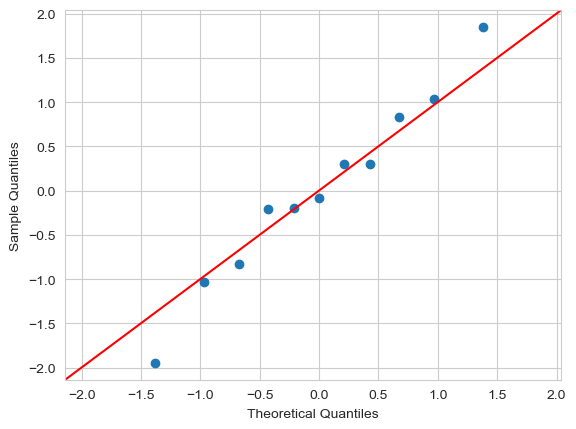

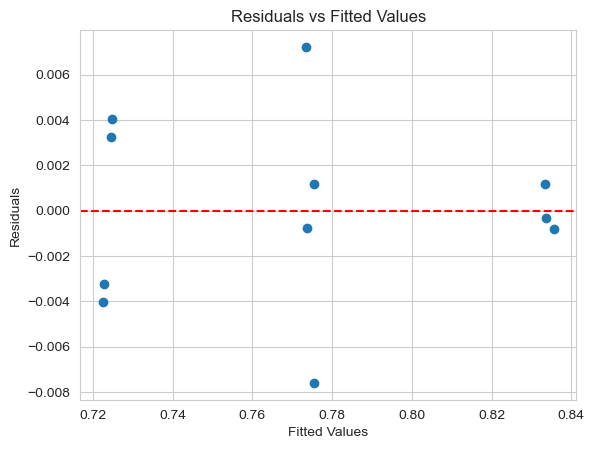

Shapiro-Wilk Test: Statistic=0.9870027927139553, P-value=0.9927611537822165
Residuals appear to be normally distributed.
Homoscedasticity likely holds (variance is constant).
Durbin-Watson Statistic: 3.028152376370032
Residuals may have autocorrelation.


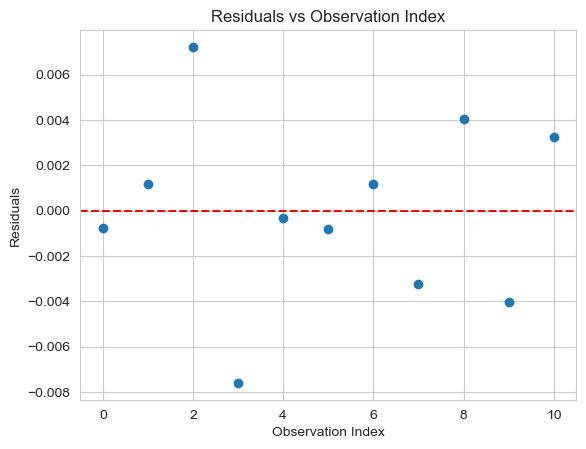

In [166]:
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
sm.qqplot(model.resid, line='45', fit=True)
plt.show()

plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

stat, p_value = shapiro(model.resid)
print(f"Shapiro-Wilk Test: Statistic={stat}, P-value={p_value}")
if p_value > 0.05:
    print("Residuals appear to be normally distributed.")
else:
    print("Residuals do not appear to be normally distributed.")

# Breusch-Pagan test
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
results = dict(zip(labels, bp_test))
if results['p-value'] > 0.05:
    print("Homoscedasticity likely holds (variance is constant).")
else:
    print("Heteroscedasticity detected (variance is not constant).")
    
from statsmodels.stats.stattools import durbin_watson

# Perform Durbin-Watson test
dw_stat = durbin_watson(model.resid)
print(f"Durbin-Watson Statistic: {dw_stat}")
if 1.5 < dw_stat < 2.5:
    print("Residuals are likely independent (no significant autocorrelation).")
else:
    print("Residuals may have autocorrelation.")

import matplotlib.pyplot as plt

# Plot residuals over observations
plt.plot(model.resid, marker='o', linestyle='')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Observation Index')
plt.ylabel('Residuals')
plt.title('Residuals vs Observation Index')
plt.show()


In [176]:
results_dirs = [f'FewShots_results(1)/Run{i}' for i in range(1, 4)]
results = load_experiment_results(results_dirs)

# Convert results to a DataFrame
df = pd.DataFrame(results)

# Group by the experiment description and calculate the mean for each metric
grouped_df = df.groupby('description').mean().reset_index()

properties = ['ex1','ex2','size','torch_dtype','shot','trunc']
grouped_df[properties] = grouped_df['description'].str.split('_', expand=True)
grouped_df['accuracy'] = grouped_df['accuracy'].astype(float)
grouped_df['unknown'] = grouped_df['unknown'].astype(float)
grouped_df['prediction_ratio'] = grouped_df['prediction_ratio'].astype(float)
grouped_df['actual_ratio'] = grouped_df['actual_ratio'].astype(float)
grouped_df.drop(columns=['description'], inplace=True)
grouped_df.drop(columns=['ex1'], inplace=True)
grouped_df.drop(columns=['ex2'], inplace=True)
grouped_df.drop(columns=['begin_time'], inplace=True)
grouped_df.drop(columns=['end_time'], inplace=True)

# Order dataframe split -> side -> size -> torch_dtype -> accuracy -> unknown -> total_time
df_ordered = grouped_df[['size', 'shot', 'torch_dtype', 'trunc', 'accuracy', 'unknown', 'total_time', 'prediction_ratio', 'actual_ratio']].copy()

model_trunced = ols('accuracy ~ C(size) + C(shot) + C(torch_dtype) + C(trunc)', data=df_ordered).fit()

# Perform ANOVA to see the effect of each factor
anova_table = sm.stats.anova_lm(model_trunced, typ=2)
print("ANOVA Table:")
print(anova_table)
model_trunced.summary()

ANOVA Table:
                      sum_sq    df           F        PR(>F)
C(size)         3.667805e-02   2.0  450.053369  2.818570e-11
C(shot)         1.564576e-05   1.0    0.383959  5.481123e-01
C(torch_dtype)  3.851852e-08   1.0    0.000945  9.760234e-01
C(trunc)        7.486673e-03   1.0  183.728555  3.294800e-08
Residual        4.482341e-04  11.0         NaN           NaN


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  res = hypotest_fun_out(*samples, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               accuracy   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     238.7
Date:                Sat, 16 Nov 2024   Prob (F-statistic):           7.90e-11
Time:                        17:42:36   Log-Likelihood:                 65.497
No. Observations:                  17   AIC:                            -119.0
Df Residuals:                      11   BIC:                            -114.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           0.8253      0.004    217.972      0.000       0.817       0.834
C(size)[T.large]                    0.0602      0.004     15.406      0.000       0.052       0.069
C(size)[T.small]                   -0.0569      0.004    -15.442      0.000      -0.065      -0.049
C(shot)[T.4]                        0.0024      0.004      0.620      0.548      -0.006       0.011
C(torch_dtype)[T.torch.float32]   9.63e-05      0.003      0.031      0.976      -0.007       0.007
C(trunc)[T.50]                     -0.0500      0.004    -13.555      0.000      -0.058      -0.042
==============================================================================
Omnibus:                        0.899   Durbin-Watson:                   2.509
Prob(Omnibus):                  0.638   Jarque-Bera (JB):                0.851
Skew:                          -0.394   Prob(JB):                        0.653
Kurtosis:                       2.239   Cond. No.                         5.13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

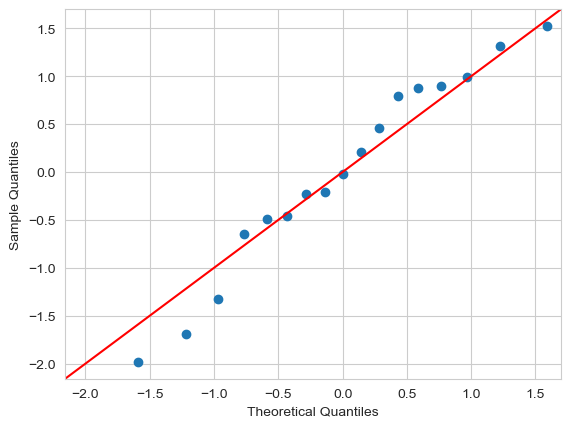

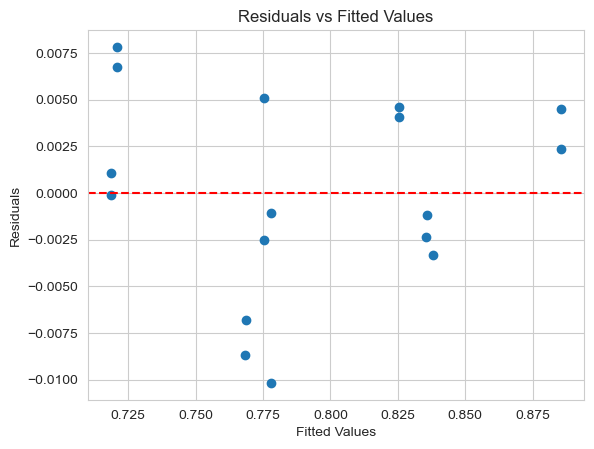

Shapiro-Wilk Test: Statistic=0.9566077376289385, P-value=0.5688511341584199
Residuals appear to be normally distributed.
Homoscedasticity likely holds (variance is constant).
Durbin-Watson Statistic: 2.509261646313069
Residuals may have autocorrelation.


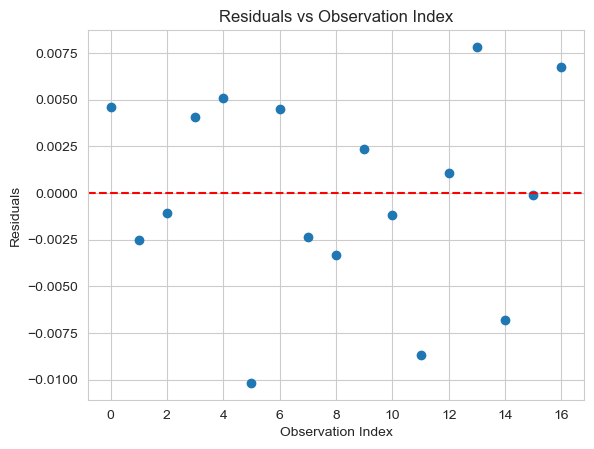

In [178]:
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
sm.qqplot(model_trunced.resid, line='45', fit=True)
plt.show()

plt.scatter(model_trunced.fittedvalues, model_trunced.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

stat, p_value = shapiro(model_trunced.resid)
print(f"Shapiro-Wilk Test: Statistic={stat}, P-value={p_value}")
if p_value > 0.05:
    print("Residuals appear to be normally distributed.")
else:
    print("Residuals do not appear to be normally distributed.")

# Breusch-Pagan test
bp_test = het_breuschpagan(model_trunced.resid, model_trunced.model.exog)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
results = dict(zip(labels, bp_test))
if results['p-value'] > 0.05:
    print("Homoscedasticity likely holds (variance is constant).")
else:
    print("Heteroscedasticity detected (variance is not constant).")
    
from statsmodels.stats.stattools import durbin_watson

# Perform Durbin-Watson test
dw_stat = durbin_watson(model_trunced.resid)
print(f"Durbin-Watson Statistic: {dw_stat}")
if 1.5 < dw_stat < 2.5:
    print("Residuals are likely independent (no significant autocorrelation).")
else:
    print("Residuals may have autocorrelation.")

import matplotlib.pyplot as plt

# Plot residuals over observations
plt.plot(model_trunced.resid, marker='o', linestyle='')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Observation Index')
plt.ylabel('Residuals')
plt.title('Residuals vs Observation Index')
plt.show()



> TODO: Write your report here, using appropriate tables, and or $math$, to support your claim.

Make sure to clearly state (among others):

 1. Which hyper-parameters you are testing.
 2. Which levels you are testing for each experiment.
 3. How many repetitions you use.
 4. Which design of experiment you use: full-factorial / fractional-factorial.
 5. Whether the assumptions of the model hold.

## Design of Experiments Report
I chose to test the following parameters:
- shots: 2, 6
- size: small, base, large
- torch_dtype: torch.float16, torch.float32

I ran the experiment full-factorial with 3 repetitions and subsampled the dataset to 5000 samples. Meaning I ran 2 * 2 * 3 * 3 = 36 experiments.
### Normality
This was checked with the Shapiro-Wilk test and the QQ-plot, which showed that the residuals appear to be normally distributed.
### Homoeostatic
This was checked with the Breusch-Pagan test, which showed that the variance is constant and the Residuals vs Fitted Values plot. Both indicated that the homoeostatic assumption holds.
### Independence of Residuals
I ran the Durbin-Watson test, which showed to have negative autocorrelation, because of the value was larger than 2.5. To double check this, I plotted the Residuals vs Observation Index plot, which showed no clear pattern. Therefore, I assume the residuals are independent and the negativ auto correlation is due to the small sample size.
### ANOVA
We can see in the OLS summary that the model as a whole is significant due to ($p$ < 0.05), meaning that at least one predictor contributes to explaining the variability in accuracy.
The size is the only significant factor in the ANOVA table, with a $p$-value of 5.485e-7. The other factors are not significant, with $p$-values of 0.5 and 0.9 indicting no effect on the accuracy. 
R-squared is 0.992 indicating the model explains 99.2% of the variance in accuracy.
Large size increases accuracy +0.06.
Small size decreases accuracy -0.05.

It is surprizing to me the little impact the shots had on the accuracy. In a previous experiment I ran with 6 shots instead of 4 and truncating the dataset to a length of 100 per shot instead of 50, which resulted in a large number of unknows due to cutting of the actual review (max lenght for prompt). The 2 shot instead increased in accuracy with a longer shot review. 
When combining the data from the two elements and running the ANOVA again, the shots factor was still not significant, but the trunc factor was. This indicates that the length of the shot has a larger impact on the accuracy than the number of shots. In the second anova table we can see that the trunc : 50 reduces the accuracy by the same amount as the small size. 

In the end size is still the most important factor for the accuracy of the model followed by trunc, the other factors were insignificant.

# Exercise 3: Fine-Tuning Based Classification (20 points total)

Lastly, we will perform a fine-tuning based approach, where we will update the model weights in order to 'learn' reply with the clasification of the sentiment of the sentence.

**N.B.** We provide most of the code here, as there are multiple non-trivial implementation details. However, the run-time is likely quitea bit longer, so make sure tostart in time.


Here we would like to advise to;

1. Carefully choose **which hyper-parameters** you want to evaluate, before diving into the implementation, make sure to check that you can reasonably run these experiment within reasonable time.
   1. We strongly recommend using a LORA based approach, and focus on; different `target_modules`, `rank`, `alpha`, `drop_out`, and `epochs`.
   2. Prefer low values for levels over higher, e.g., a level for epochs can be `1`, or for `steps=100`.
   3. You can also try to fine-tune the model, and see whether the fine-tuned model is still capable to perform.
   4. If your hardware / pytorch version allows, we also strongly recommend using `bitsandbytes` to further quantize the model, which will speed-up your experiments considerably.
2. Preferably run with replication, i.e., at-least a `REPLICATION` of `2`, but if time does not permit for this, a single run is OK as well.
3. Look into check-pointing, and recovery, and how much disk-space you need for your experiments.
4. Check that you save models to recoverable paths, i.e., you don't overwrite models you train.


## Exercise 3.1: Perform DoE (10 points)

First, you will need to complete the following code to Design your experiments.

> Note, running training will take some time, so make sure to get started early!


In [33]:
from peft import LoraConfig, get_peft_model, TaskType


def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

def tokenize_function(
        batch,
        prefix='Is the following Positive or Negative?\n',
        post_fix='\nAnswer: '):

    updated_text = [f"{prefix}{review}{post_fix}" for review in batch["text"]]
    batch['text'] = updated_text
    # We also set the 'response', i.e., what the model should learn
    batch['labels'] = tokenizer(
        ['Positive' if label == 1 else 'Negative' for label in batch["label"]],
        truncation=True,
        padding='max_length',
        return_tensors="pt"
    ).input_ids.squeeze()  # Remove extra dimension if it causes conflicts
    
    return batch

def train_model(
        peft_model,
        output_dir: str,
        peft_training_args,
        train_set,
        test_set = None,

) -> Tuple[transformers.Trainer, peft.PeftModel]:
    assert output_dir is not None, "Provide an output dir to save the model"
    assert not Path(output_dir).exists(), "Provided output dir is not unique!"

    peft_trainer = transformers.Trainer(
        model=peft_model,
        args=peft_training_args,
        train_dataset=train_set,
        eval_dataset=test_set,
    )
    # Pre-train the model
    peft_trainer.train()
    # Set the fine-tuned model to evaluate, to remove non-deterministic
    #  behavior.
    peft_model.eval()
    return peft_model, peft_trainer


In [34]:
# Example of hyper-parameters.
RANK = 32               # Rank used in model update (lower is faster, less precise)
ALPHA = 64              # Scaling factor for update (∆W x dy ALPHA/RANK)
DROPOUT = 0.1          # Regularization term
TRAIN_BATCH_SIZE = 32   # Number of samples
# GRADIENT_ACCUMULATION_STEPS=1 # If you have low GPU/hardware, you can increase effective batch-size through this.
#                               # It 'sums' gradient over GRADIENT_ACCUMULATION_STEPS, to create an effective-batch-size of
#                               # GRADIENT_ACCUMULATION_STEPS * TRAIN_BATCH_SIZE
TRAIN_EPOCHS = 5        # Total number of trainnig steps.

# If you want to save some time, you can store checkpoints, and load them, to create multiple levels
# in a single run. Do note, that huggingface by default uses learning-rate scheduling, so this may
# affect your results a bit.

# The modules are specific to the model itself.
MODULES =  ['o'] # Other options are for example, please read the documentation.
                 # ['o'], ['k', 'q'], ['q'], ['k', 'q', 'v'], 'or any other identifier of weights.
TORCH_DTYPE = torch.float16

# TODO: Decide the levels for your experiment. These can be any of the
# aforementioned parameters, or any other hyper-parameter.

# Hint: Define the levels as a list of numbers for the unique count of
#   levels for a parameter.

levels = [2, 2, 2]
level_names = ['rank', 'alpha', 'modules']
parameter_levels = {
    'rank': [8, 16],
    'alpha': [16, 32], 
    'modules': [['k','q'], ['k','q','v']],    
}

# EXAMPLE ONLY
# Don't actually use this configuration, as this will be a 3 * 2 * 2 * 3 = 36 experiments (without replication)
# levels = [3, 2, 2, 3]
# level_names = ['rank', 'alpha', 'dtype',  'epochs']
# parameter_levels = {
#     'rank': [8, 16, 32],
#     'alpha': [16, 32],
#     'dtype': [torch.float16, torch.float32],
#     'epochs': [1, 2, 3]
# }
# END OF EXAMPLE
# YOUR CODE GOES HERE

# END OF YOUR CODE

In [35]:
# TODO: Decide the type of (fractional or full) factorial experiment you want to run.
# HINT: use the ANOVAandDOE.ipynb notebook as inspiration, and use functinos from pyDOE3
import pyDOE3
import pandas as pd
# EXAMPLE ONLY
reduction = 2  # Experiment with this value to find an optimal balance
experiment = pyDOE3.gsd(
    levels,
    reduction=reduction,
)
# END OF EXAMPLE

# YOUR CODE GOES HERE

# END OF YOUR CODE

experiment_configs = pd.DataFrame(
    experiment,
    columns=[level_names],

)
experiment_configs.index.name = 'Experiment ID'


display(
    experiment_configs,
)


,rank,alpha,modules
Experiment ID,,,
0,0,0,0
1,0,1,1
2,1,0,1
3,1,1,0


In [36]:
torch.mps.empty_cache()

RuntimeError: Cannot execute emptyCache() without MPS backend.

In [37]:
REPETITIONS = 2

# If the number of tokens is a level, you might need to change this
train_dataset = (
    train_set
    .map(truncate_to_50_tokens, batched=True)
    .map(
        tokenize_function, batched=True
    )
    .map(
        lambda batch: fast_tokenizer.batch_encode_plus(
            batch['text'],
            add_special_tokens=True,
            return_tensors="pt",
            padding=True,
            truncation=False,
        ), batched=True
    )
)
# Ensure we can effectively use the model
train_dataset.set_format(type='torch', columns=['input_ids', 'labels'])
EXPERIMENT_CONFIGURATIONS = []
for repetition in range(REPETITIONS):
    for experiment_id, config_row in enumerate(experiment_configs.iterrows()):
        experiment_config = {k[0]: parameter_levels[k[0]][v] for k, v in config_row[1].to_dict().items()}
        
        EXPERIMENT_CONFIGURATIONS.append(experiment_config)
        print(f"Running experiment: {experiment_id + 1}, repetition: {repetition + 1}")
        print(f"Experiment config: {experiment_config}")
        
        # BEGIN OF YOUR UPDATE TO THIS CODE
        rank = experiment_config['rank']
        alpha = experiment_config['alpha']
        exp_dtype = torch.float16
        epochs = 2
        
        lora_config = LoraConfig(
            r=rank,
            lora_alpha=alpha,
            target_modules=experiment_config['modules'],
            lora_dropout=DROPOUT,
            bias='none',
            task_type=TaskType.SEQ_2_SEQ_LM # Specific for FLAN-T5 model.
            # task_type=TaskType.CAUSAL_LM # Specific for Auto-regressive model
            # task_type=TaskType.TOKEN_CLS # Specific for Token based classification
        )
        
        original_model, tokenizer, tokenizer_fast = get_model(
            model_name=model_name,
            device=device,
            torch_dtype=exp_dtype,
        )
        
        original_model.gradient_checkpointing_enable()
        
        output_dir = f'exercise-3_firstTry/exp_{repetition}_{experiment_id}_rank={rank}_alpha={alpha}_dtype={exp_dtype}_epochs={epochs}'

        
        peft_training_args = transformers.TrainingArguments(
            output_dir=output_dir,
            auto_find_batch_size=False,
            per_device_train_batch_size=TRAIN_BATCH_SIZE,
            learning_rate=1e-4,
            num_train_epochs=epochs,
            logging_steps=128,     # You might need to change this, esp. if you subsample the train set.
            # max_steps=10000,        # You can use this instead of epochs, for more fine-grained control.
            save_total_limit=2,     # Limit the number of checkpoints to save
            save_strategy='steps',
            save_steps=128         # You might need to change this
        )
        # END OF YOUR UPDATE CODE
        
        peft_model = get_peft_model(
            model=original_model,
            peft_config=lora_config,
        )
        peft_model, peft_trainer = train_model(
            peft_model=peft_model,
            peft_training_args=peft_training_args,
            output_dir=output_dir,
            train_set=train_dataset.shuffle().select(range(500)),  # Subsample the train set
            test_set=None,
        )
        peft_model.save_pretrained(output_dir)
        
        del peft_model, peft_trainer
        if device == 'mps':
            torch.mps.empty_cache()
        
        print('Finished experiment!')

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Running experiment: 1, repetition: 1
Experiment config: {'rank': 8, 'alpha': 16, 'modules': ['k', 'q']}
'NoneType' object has no attribute 'cadam32bit_grad_fp32'


/usr/local/anaconda3/lib/python3.12/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


AssertionError: Provided output dir is not unique!

In [ ]:
torch.mps.current_allocated_memory()
REPETITIONS = 2

In [38]:
# Next do the evaluation

# ONLY SET THIS TO True IFF YOU NEED TO RE-RUN EXPERIMENTS, AS IT WILL
#  OVERWRITE YOUR RESULTS.
ALLOW_OVERWRITING_RESULTS = True
"""
# If you want to experiment with the side of the prompt, you will need to make
#  some changes here.
"""

# If the number of tokens is a level, you might need to change this
test_dataset = (
    test_set
    .map(truncate_to_50_tokens, batched=True)
    .map(
        tokenize_function, batched=True
    )
    .map(
        lambda batch: fast_tokenizer.batch_encode_plus(
            batch['text'],
            add_special_tokens=True,
            return_tensors="pt",
            padding=True,
            truncation=False,
        ), batched=True
    )
)
# Ensure we can effectively use the model
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=15,  # Batch size for evaluation
    shuffle=False,
    num_workers=2,
    prefetch_factor=10,
)

EXPERIMENT_CONFIGURATIONS = []
for experiment_id, config_row in enumerate(experiment_configs.iterrows()):
    experiment_config = {k[0]: parameter_levels[k[0]][v] for k, v in config_row[1].to_dict().items()}
    
    EXPERIMENT_CONFIGURATIONS.append(experiment_config)
    
original_model, tokenizer, tokenizer_fast = get_model(
            model_name=model_name,
            device=device,
            torch_dtype=torch.float16, # You might need to change this.
)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [39]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"
print(EXPERIMENT_CONFIGURATIONS)

[{'rank': 8, 'alpha': 16, 'modules': ['k', 'q']}, {'rank': 8, 'alpha': 32, 'modules': ['k', 'q', 'v']}, {'rank': 16, 'alpha': 16, 'modules': ['k', 'q', 'v']}, {'rank': 16, 'alpha': 32, 'modules': ['k', 'q']}]


In [41]:
REPETITIONS = 2
for experiment_id, experiment_config in (exp_bar := tqdm(enumerate(EXPERIMENT_CONFIGURATIONS), leave=True)):
    for repetition in tqdm(range(REPETITIONS), leave=False):

        # Rest of your code remains the same
        test_dataloader = torch.utils.data.DataLoader(
            dataset=test_dataset.shuffle().select(range(5000)),
            batch_size=15,  # Batch size for evaluation
            shuffle=False,
            num_workers=2,
            prefetch_factor=10,
        )   

        rank = experiment_config['rank']
        alpha = experiment_config['alpha']
        exp_dtype = torch.float16
        epochs = 2

        output_dir = f'exercise-3_firstTry/exp_{repetition}_{experiment_id}_rank={rank}_alpha={alpha}_dtype={exp_dtype}_epochs={epochs}'

        peft_model = peft.PeftModel.from_pretrained(peft_model, output_dir)
        begin_time = time.time()

        prediction_list, label_list = run_q1_evaluation(
            test_dataloader,  # This you should probably not change
            peft_model,  # You might need to change / load a different model for model-parameter
            experiment_config,  # You might need to update some kwargs int the generation config for your exp.
        )
        end_time = time.time()
        # Create a flat version to work with.
        prediction_list, labels_list = list(chain(*prediction_list)), list(chain(*label_list))
        # TODO: Store your results in a way such that you can load it later!
        # YOUR CODE GOES HERE
        
        # Calculate negative to positive label ratio
        # END OF YOUR CODE

        # Map the output if we don't recognize it to
        label_lut = defaultdict(lambda: -1, {'positive': 1, 'negative': 0})

        predictions = list(map(lambda x: label_lut[x.split(' ')[0].lower()], prediction_list))
        
        pos_count = predictions.count(1)
        neg_count = predictions.count(0)
        if (neg_count + pos_count) == 0:
            pred_ratio = None
        else:
            pred_ratio = neg_count / (neg_count + pos_count)
        act_ratio = 1 - (sum(labels_list) / len(labels_list))
        
        print("pred_ratio", pred_ratio)
        print("act_ratio", act_ratio)

        accuracy = sum(map(lambda x: x[0] == x[1], zip(predictions, labels_list))) / len(predictions)
        unknown =  sum(map(lambda x: x[0] == -1, zip(predictions, labels_list))) / len(predictions)

        print(f"Accuracy (Experiment {experiment_id}, Repetition {repetition}): {accuracy}, Unknown: {unknown}")

        # Write file to disk
        save_path = Path(output_dir) / f'result_replication={repetition}.json'
        if not save_path.parent.exists():
            # Recursively create directory
            save_path.parent.mkdir(exist_ok=True, parents=True)
        if save_path.is_file() and not ALLOW_OVERWRITING_RESULTS:
            print("YOU ARE TRYING TO OVERWRITE AN EXISTING EXPERIMENT FILE!")
            raise Exception("Cannot overwrite existing experiment file without `ALLOW_OVERWRITING_RESULTS` flag set.")

        with open(save_path, 'w') as f:
            # TODO: You might want to save some additional results.
            json.dump({
                "experiment_config": experiment_config,
                "accuracy": accuracy,
                "unknown": unknown,
                "prediction_ratio": pred_ratio,
                "actual_ratio": act_ratio,
                "begin_time": begin_time,
                "end_time": end_time,
                "total_time": end_time - begin_time,
            }, f)


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/334 [00:00<?, ?it/s]

pred_ratio 0.6378
act_ratio 0.505
Accuracy (Experiment 0, Repetition 0): 0.7344, Unknown: 0.0


  0%|          | 0/334 [00:00<?, ?it/s]

pred_ratio 0.6264
act_ratio 0.49760000000000004
Accuracy (Experiment 0, Repetition 1): 0.7356, Unknown: 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/334 [00:00<?, ?it/s]

pred_ratio 0.6392557022809123
act_ratio 0.5025999999999999
Accuracy (Experiment 1, Repetition 0): 0.7256, Unknown: 0.0004


  0%|          | 0/334 [00:00<?, ?it/s]

pred_ratio 0.6272
act_ratio 0.493
Accuracy (Experiment 1, Repetition 1): 0.7442, Unknown: 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/334 [00:00<?, ?it/s]

pred_ratio 0.6414
act_ratio 0.501
Accuracy (Experiment 2, Repetition 0): 0.7412, Unknown: 0.0


  0%|          | 0/334 [00:00<?, ?it/s]

pred_ratio 0.6426
act_ratio 0.5018
Accuracy (Experiment 2, Repetition 1): 0.7292, Unknown: 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/334 [00:00<?, ?it/s]

pred_ratio 0.6405281056211243
act_ratio 0.5008
Accuracy (Experiment 3, Repetition 0): 0.7388, Unknown: 0.0002


  0%|          | 0/334 [00:00<?, ?it/s]

pred_ratio 0.6445289057811562
act_ratio 0.5084
Accuracy (Experiment 3, Repetition 1): 0.7424, Unknown: 0.0002


## Excercise 3.2 Experimental Analysis (10 points)

In [192]:
 # TODO: Put your code here to perform DoE

 # 1. Load data
def load_experiment_results(results_dirs: List[str]) -> List[Dict]:
    results = []
    for results_dir in results_dirs:
        for result_file in Path(results_dir).rglob('*.json'):
            if 'result_replication' in result_file.name:
                with open(result_file, 'r') as f:
                    results.append(json.load(f))
                    
    df = pd.DataFrame(results)
    
    df = df.join(pd.json_normalize(df.pop(df.columns[0])))
    
    return df

directories = []
for experiment_id, experiment_config in enumerate(EXPERIMENT_CONFIGURATIONS):
    for repetition in range(REPETITIONS):
        rank = experiment_config['rank']
        alpha = experiment_config['alpha']
        exp_dtype = torch.float16
        epochs = 3
        
        output_dir = f'exercise-3_GoodModels0DoE/exp_{repetition}_{experiment_id}_rank={rank}_alpha={alpha}_dtype={exp_dtype}_epochs={epochs}'
        directories.append(output_dir)
        
df = load_experiment_results(directories)

len(df)
 # 2. Create model and fit

 # 3. Check assumptions

8

In [193]:
df

,accuracy,unknown,prediction_ratio,actual_ratio,begin_time,end_time,total_time,rank,alpha,modules
0,0.7380,0.0000,0.641000,0.4966,1.731493e+09,1.731495e+09,2030.431901,8,16,[o]
1,0.7442,0.0000,0.641000,0.5080,1.731495e+09,1.731497e+09,2341.596869,8,16,[o]
2,0.7360,0.0000,0.636400,0.5000,1.731497e+09,1.731500e+09,2840.762692,8,32,"[k, q]"
3,0.7406,0.0002,0.636527,0.5038,1.731500e+09,1.731502e+09,2323.908030,8,32,"[k, q]"
4,0.7234,0.0000,0.634200,0.4940,1.731502e+09,1.731504e+09,1778.064314,16,16,"[k, q]"
5,0.7364,0.0002,0.640728,0.5074,1.731504e+09,1.731506e+09,1637.424775,16,16,"[k, q]"
6,0.7378,0.0000,0.641200,0.5118,1.731506e+09,1.731507e+09,1659.803232,16,32,"[k, q, v]"
7,0.7296,0.0004,0.629252,0.4910,1.731507e+09,1.731509e+09,1788.655111,16,32,"[k, q, v]"


In [187]:
df['modules'] = df['modules'].apply(lambda x: ','.join(sorted(x.strip('[]').replace(' ', '').split(','))) if isinstance(x, str) else str(x))
# Group by 'rank', 'alpha', and 'modules', and calculate the mean for each metric
grouped_df = df.copy()

grouped_df['modules'] = grouped_df['modules'].astype('category')
grouped_df['rank'] = grouped_df['rank'].astype('category')
grouped_df['alpha'] = grouped_df['alpha'].astype('category')
grouped_df['accuracy'] = grouped_df['accuracy'].astype(float)
grouped_df['unknown'] = grouped_df['unknown'].astype(float)
grouped_df['prediction_ratio'] = grouped_df['prediction_ratio'].astype(float)
grouped_df['actual_ratio'] = grouped_df['actual_ratio'].astype(float)
grouped_df.drop(columns=['begin_time'], inplace=True)
grouped_df.drop(columns=['end_time'], inplace=True)

df_ordered = grouped_df[['rank', 'alpha', 'modules', 'accuracy', 'unknown', 'total_time', 'prediction_ratio', 'actual_ratio']].copy()

# Fit the model
model = ols('accuracy ~ C(rank) + C(alpha) + C(modules)', data=df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print("ANOVA Table:")
print(anova_table)
model.summary()

ANOVA Table:
            sum_sq   df         F    PR(>F)
C(rank)   0.000125  1.0  4.400235  0.080737
Residual  0.000170  6.0       NaN       NaN


/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  res = hypotest_fun_out(*samples, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               accuracy   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     4.400
Date:                Sat, 16 Nov 2024   Prob (F-statistic):             0.0807
Time:                        19:21:26   Log-Likelihood:                 31.680
No. Observations:                   8   AIC:                            -59.36
Df Residuals:                       6   BIC:                            -59.20
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.7397      0.003    277.768      0.000       0.733       0.746
C(rank)[T.16]    -0.0079      0.004     -2.098      0.081      -0.017       0.001
==============================================================================
Omnibus:                        0.395   Durbin-Watson:                   2.653
Prob(Omnibus):                  0.821   Jarque-Bera (JB):                0.453
Skew:                          -0.323   Prob(JB):                        0.797
Kurtosis:                       2.030   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [188]:
df_ordered

,rank,alpha,modules,accuracy,unknown,total_time,prediction_ratio,actual_ratio
0,8,16,'o',0.7380,0.0000,2030.431901,0.641000,0.4966
1,8,16,'o',0.7442,0.0000,2341.596869,0.641000,0.5080
2,8,32,"'k','q'",0.7360,0.0000,2840.762692,0.636400,0.5000
3,8,32,"'k','q'",0.7406,0.0002,2323.908030,0.636527,0.5038
4,16,16,"'k','q'",0.7234,0.0000,1778.064314,0.634200,0.4940
5,16,16,"'k','q'",0.7364,0.0002,1637.424775,0.640728,0.5074
6,16,32,"'k','q','v'",0.7378,0.0000,1659.803232,0.641200,0.5118
7,16,32,"'k','q','v'",0.7296,0.0004,1788.655111,0.629252,0.4910


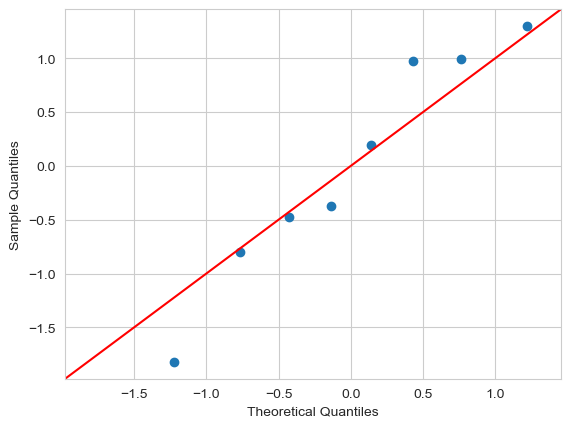

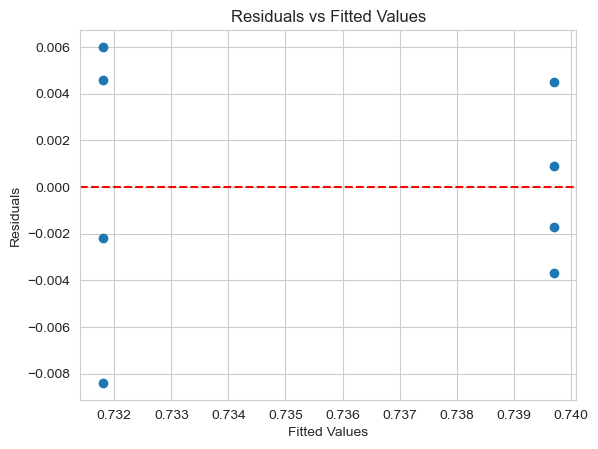

Shapiro-Wilk Test: Statistic=0.9414345301092127, P-value=0.6252481390965354
Residuals appear to be normally distributed.
Homoscedasticity likely holds (variance is constant).
Durbin-Watson Statistic: 2.652937720329062
Residuals may have autocorrelation.


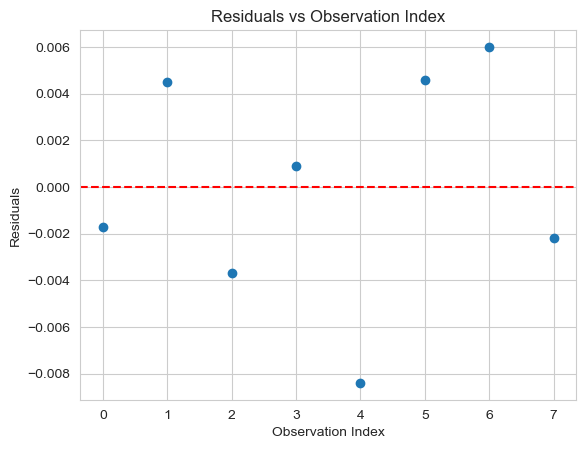

In [189]:
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
sm.qqplot(model.resid, line='45', fit=True)
plt.show()

plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

stat, p_value = shapiro(model.resid)
print(f"Shapiro-Wilk Test: Statistic={stat}, P-value={p_value}")
if p_value > 0.05:
    print("Residuals appear to be normally distributed.")
else:
    print("Residuals do not appear to be normally distributed.")

# Breusch-Pagan test
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
results = dict(zip(labels, bp_test))
if results['p-value'] > 0.05:
    print("Homoscedasticity likely holds (variance is constant).")
else:
    print("Heteroscedasticity detected (variance is not constant).")
    
from statsmodels.stats.stattools import durbin_watson

# Perform Durbin-Watson test
dw_stat = durbin_watson(model.resid)
print(f"Durbin-Watson Statistic: {dw_stat}")
if 1.5 < dw_stat < 2.5:
    print("Residuals are likely independent (no significant autocorrelation).")
else:
    print("Residuals may have autocorrelation.")

import matplotlib.pyplot as plt

# Plot residuals over observations
plt.plot(model.resid, marker='o', linestyle='')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Observation Index')
plt.ylabel('Residuals')
plt.title('Residuals vs Observation Index')
plt.show()


In [88]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import scipy.stats as stats

# Define the model with log_accuracy as the dependent variable
model = ols('accuracy ~ C(rank) + C(alpha) + C(modules)', data=df_ordered).fit()

# Perform ANOVA to see the effect of each factor
anova_table = sm.stats.anova_lm(model, typ=2)
print("ANOVA Table:")
anova_table

/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1718: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/statsmodels/base/model.py:1527: RuntimeWarning: invalid value encountered in multiply
  cov_p = self.normalized_cov_params * scale


ValueError: array must not contain infs or NaNs

# TODO: Write your report here, using appropriate tables, and or $math$, to support your claim.

Make sure to clearly state (among others):

1. Which hyper-parameters you are testing
2. Which levels you are testing for each experiment
3. How many repetitions you use
4. Which design of experiment you use: full-factorial / fractional-factorial.
5. Whether the assumptionsn of hte model hold


# DoE Report for Exercise 3

I chose to test the following parameters:
- rank: 8, 16
- alpha: 16, 32
- modules: ['o'], ['k','q'], ['k','q','v']
- epochs: 3
- repetitions: 2


NameError: name '__file__' is not defined